# Notebook 4: Analysis (2) => TIME SERIES analysis, modeling and forecasting

In [1]:
import pandas as pd
import numpy as np
import calendar
import datetime
import folium
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Loading my csv with all the traffic information from 2015-01 to 2019-04 of all the devices chosen for the analysis

final_data = pd.read_csv('final_data.csv', sep = ';')

## Second part of the analysis:
#### now considering the whole dataset I will forecast the situation of all the devices including Madrid Central observations in the model

## Focus on GENOVA West-East

In [375]:
# For this time it is not necessary to split the dataframe

genova_WE = final_data[final_data['id'] == 3850]

In [376]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

genova_WE = genova_WE.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
genova_WE = genova_WE.set_index(genova_WE['Año_mes'])
genova_WE.index = pd.to_datetime(genova_WE.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_genova_WE = genova_WE['intensidad'].resample('M').mean()

In [377]:
series_genova_WE.tail(20)

Año_mes
2017-09-30    1402.736636
2017-10-31    1392.495252
2017-11-30    1418.721344
2017-12-31    1401.150722
2018-01-31    1433.626603
2018-02-28    1478.002626
2018-03-31    1376.464782
2018-04-30    1451.512255
2018-05-31    1381.287951
2018-06-30    1441.025000
2018-07-31    1276.772273
2018-08-31    1043.610451
2018-09-30    1428.644051
2018-10-31    1496.549856
2018-11-30    1505.792157
2018-12-31    1373.146584
2019-01-31    1284.059886
2019-02-28    1442.396217
2019-03-31    1480.481375
2019-04-30    1440.776028
Freq: M, Name: intensidad, dtype: float64

Text(0.5, 1.0, 'Time Series Genova West-East')

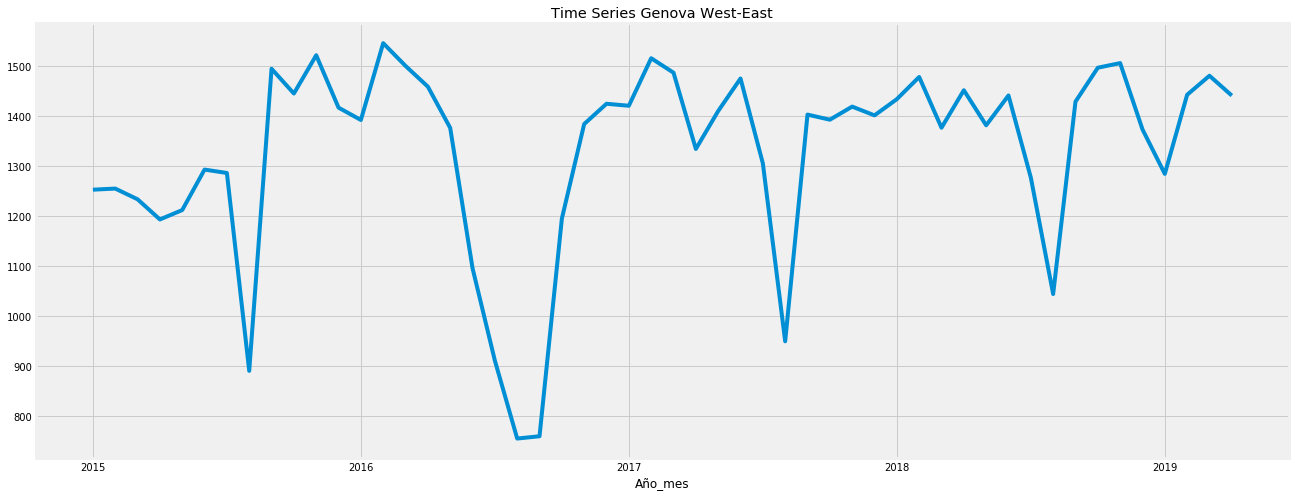

In [378]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_genova_WE.plot()
plt.title('Time Series Genova West-East')

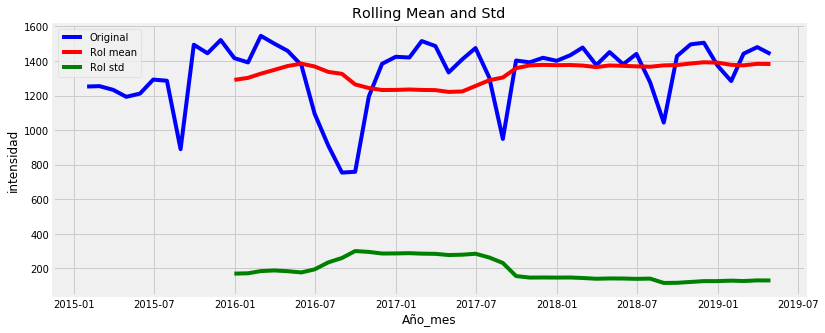

In [379]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_genova_WE = series_genova_WE.rolling(12).mean()
rolstd_genova_WE = series_genova_WE.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_genova_WE, label = 'Original', color = 'blue')
plt.plot(rolmean_genova_WE, label = 'Rol mean', color = 'red')
plt.plot(rolstd_genova_WE, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

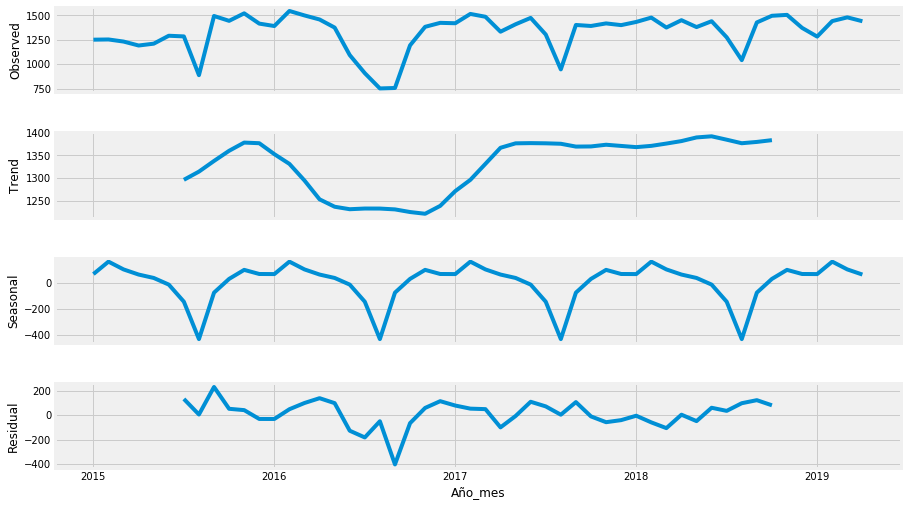

In [380]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_genova_WE, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [381]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_genova_WE, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# We can confirm the serie is stationary since the obtained p-value < 0.05

Test statistic: -3.518512331189379
p-value: 0.007524193579534634
Lag: 1
Number of observations: 50
Critical Value (1%) = -3.568485864
Critical Value (5%) = -2.92135992
Critical Value (10%) = -2.5986616


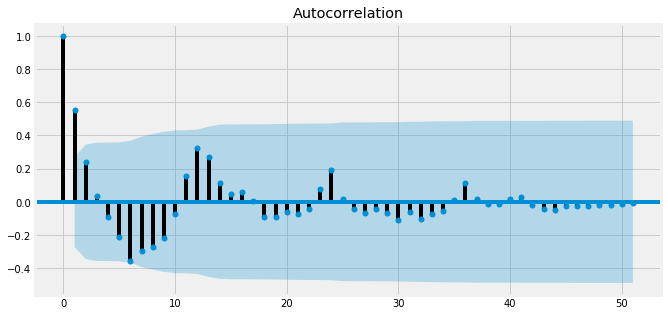

In [382]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_genova_WE)
fig.set_size_inches(10,5)

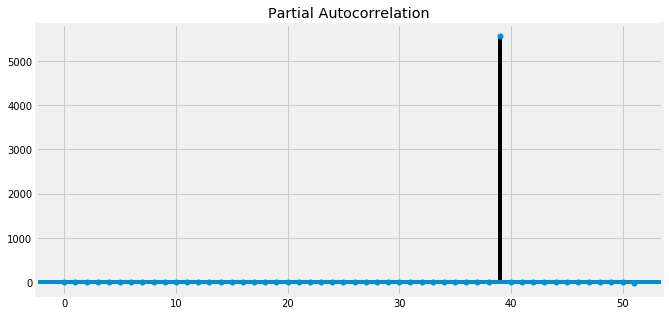

In [383]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_genova_WE)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [384]:
len(series_genova_WE)

52

In [385]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_genova_WE = series_genova_WE.loc['2015-01-31':'2018-12-31']
test_genova_WE = series_genova_WE.loc['2019-01-01':'2019-04-30']

In [386]:
len(train_genova_WE), len(test_genova_WE)

(48, 4)

In [387]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_genova_WE, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_genova_WE['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:829.2356748590964 - p-values:sigma2    0.370238
dtype: float64
The Mean Squared Error of our forecasts is 1999244.33
The Root Mean Squared Error of our forecasts is 1413.95
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:496.83069695613153 - p-values:sigma2    7.477004e-10
dtype: float64
The Mean Squared Error of our forecasts is 8643.18
The Root Mean Squared Error of our forecasts is 92.97
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:488.619627460897 - p-values:ar.S.L12    3.055844e-09
sigma2      5.141954e-06
dtype: float64
The Mean Squared Error of our forecasts is 7052.19
The Root Mean Squared Error of our forecasts is 83.98
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:775.5748396291765 - p-values:ma.L1     1.346900e-19
sigma2    4.494144e-02
dtype: float64
The Mean Squared Error of our forecasts is 1769907.91
The Root Mean Squared Error of our forecasts is 1330.38
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:489.34987853751863 - p-values:ma.L1     1.124207e-01
sigma2    9.250205

In [388]:
# We select the model SARIMAX(0, 0, 1)x(1, 1, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05


mod = sm.tsa.statespace.SARIMAX(train_genova_WE,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   48
Model:             SARIMAX(0, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -235.850
Date:                            Thu, 16 May 2019   AIC                            477.699
Time:                                    12:04:19   BIC                            482.450
Sample:                                01-31-2015   HQIC                           479.357
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5104      0.186      2.752      0.006       0.147       0.874
ar.S.L12      -0.6341      0.073   

In [389]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([ 1.25243665e+03,  1.23004041e+03,  1.20905854e+03,  1.16906808e+03,
        1.18865707e+03,  1.26928020e+03,  1.26092535e+03,  8.65017939e+02,
        1.47743337e+03,  1.41584068e+03,  1.49365676e+03,  1.40257372e+03,
        1.65342446e+02,  2.92037594e+02,  1.93721948e+02,  2.35294753e+02,
        1.12849789e+02, -1.84757920e+02, -2.17840434e+02,  3.27558382e+01,
       -6.80370217e+02,  1.70803256e+02, -1.46369582e+02,  1.45714871e+02,
        6.67657479e+01,  1.22947480e+02,  9.41785614e+01, -3.99687838e+00,
        1.40091646e+02,  1.83031047e+02,  6.33105461e+01,  7.63955871e+01,
        1.38439843e+02, -3.14064835e+01, -3.63826389e+01,  2.40239593e-01,
        3.11359617e+01, -7.25049800e+01, -8.16896832e+01,  8.02024711e+01,
       -4.80583499e+01,  2.31293990e+02,  1.03766112e+02,  1.65044967e+02,
        3.49857160e+02,  5.10711336e+01,  8.31073233e+01, -8.51742064e+01])

In [390]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.727 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=4.760262354987702, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [391]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 35.03606355,  66.43100689,  90.49741476, 109.30679962,
        125.82611671, 136.49733916, 143.05063115, 147.68979988,
        148.78845036, 149.08765825, 149.16423741, 150.20357903]),
 array([3.23655124e-09, 3.75569348e-15, 1.71283712e-19, 1.02287307e-22,
        1.82807404e-25, 5.49367333e-27, 1.16614748e-27, 5.94480234e-28,
        1.57172351e-27, 5.74216437e-27, 2.20819875e-26, 5.15548862e-26]),
 array([ 32.93389974,  61.81724761,  83.4770147 , 100.02927337,
        114.23588606, 123.19971293, 128.57341236, 132.28474734,
        133.14169472, 133.36909271, 133.42576129, 134.17408726]),
 array([9.53460968e-09, 3.77185717e-14, 5.50848589e-18, 9.69647922e-21,
        5.21038267e-23, 3.46537104e-24, 1.24829118e-24, 9.50304309e-25,
        2.67660331e-24, 9.58508874e-24, 3.52283393e-23, 8.94483787e-23]))

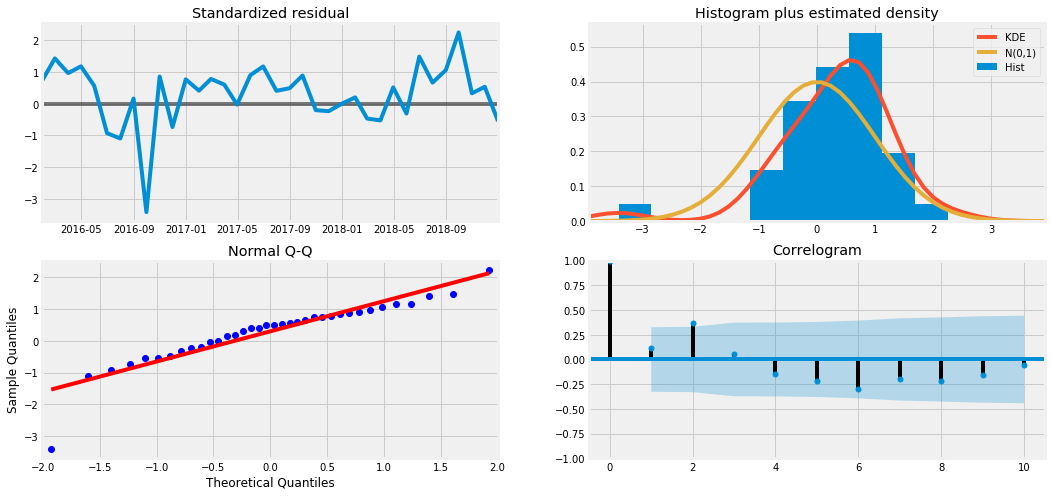

In [392]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

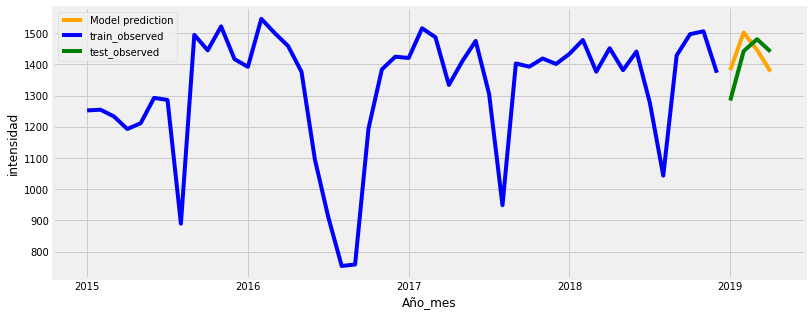

In [393]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_genova_WE.plot(color = 'blue', label = 'train_observed')
test_genova_WE.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [394]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    1381.766922
2019-02-28    1501.781864
2019-03-31    1446.289184
2019-04-30    1376.963190
Freq: M, dtype: float64

In [395]:
# Test values to compare vs forecasted values

y_truth = test_genova_WE['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    1284.059886
2019-02-28    1442.396217
2019-03-31    1480.481375
2019-04-30    1440.776028
Freq: M, Name: intensidad, dtype: float64

In [396]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_genova_WE['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 4578.63
The Root Mean Squared Error of our forecasts is 67.67


## Applying the model

In [397]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(series_genova_WE,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   52
Model:             SARIMAX(0, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -259.884
Date:                            Thu, 16 May 2019   AIC                            525.768
Time:                                    12:04:24   BIC                            530.834
Sample:                                01-31-2015   HQIC                           527.600
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5282      0.161      3.285      0.001       0.213       0.843
ar.S.L12      -0.6566      0.063   

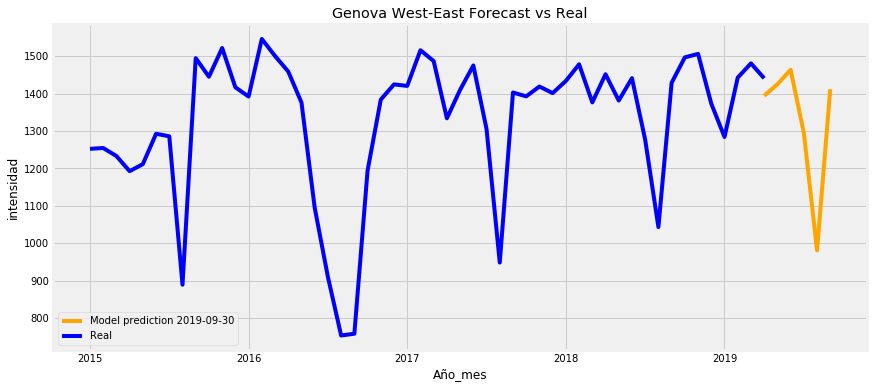

In [399]:
# Plot to forecast

plt.figure(figsize=(13,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_genova_WE.plot(color = 'blue', label='Real')

plt.title('Genova West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

## Focus on PRINCESA North-South

In [350]:
# For this time it is not necessary to split the dataframe

princesa_NS = final_data[final_data['id'] == 4354]

In [351]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

princesa_NS = princesa_NS.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
princesa_NS = princesa_NS.set_index(princesa_NS['Año_mes'])
princesa_NS.index = pd.to_datetime(princesa_NS.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_princesa_NS = princesa_NS['intensidad'].resample('M').mean()

In [352]:
series_princesa_NS.tail()

Año_mes
2018-12-31    722.540104
2019-01-31    707.035255
2019-02-28    813.761123
2019-03-31    893.070431
2019-04-30    790.807009
Freq: M, Name: intensidad, dtype: float64

Text(0.5, 1.0, 'Time Series Princesa North-South')

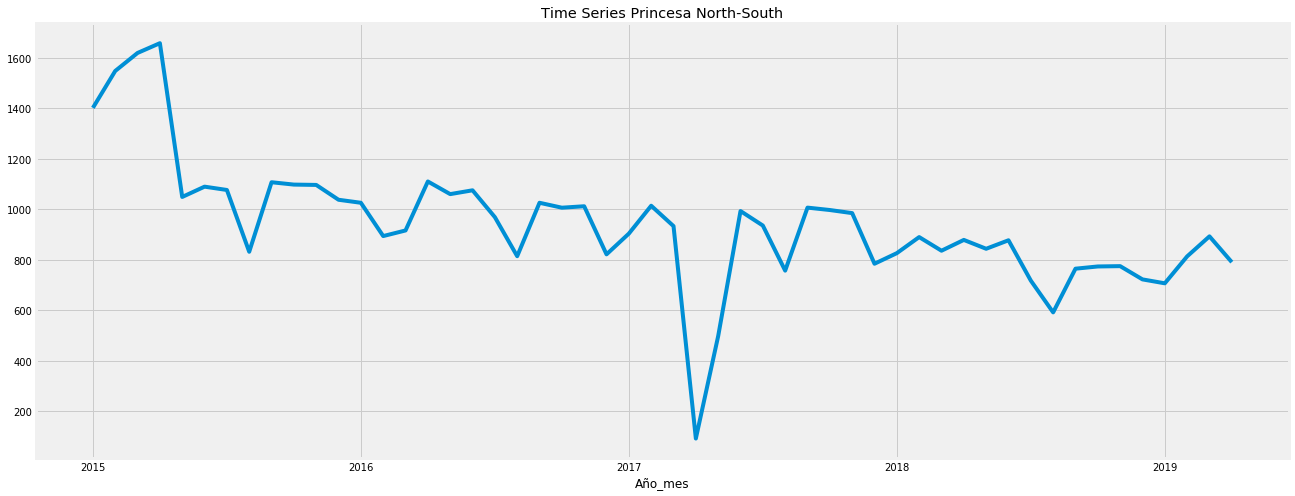

In [353]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_princesa_NS.plot()
plt.title('Time Series Princesa North-South')

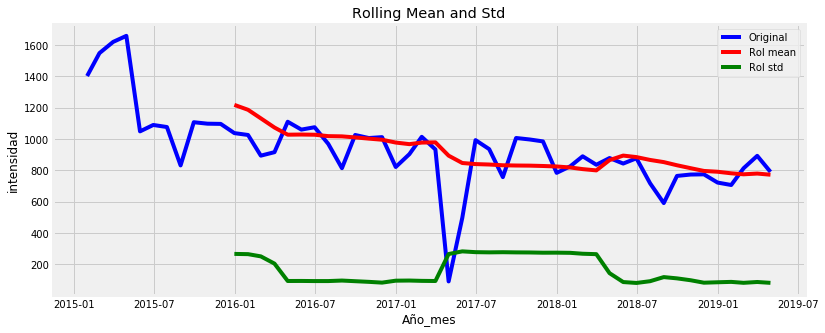

In [354]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_princesa_NS = series_princesa_NS.rolling(12).mean()
rolstd_princesa_NS = series_princesa_NS.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_princesa_NS, label = 'Original', color = 'blue')
plt.plot(rolmean_princesa_NS, label = 'Rol mean', color = 'red')
plt.plot(rolstd_princesa_NS, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

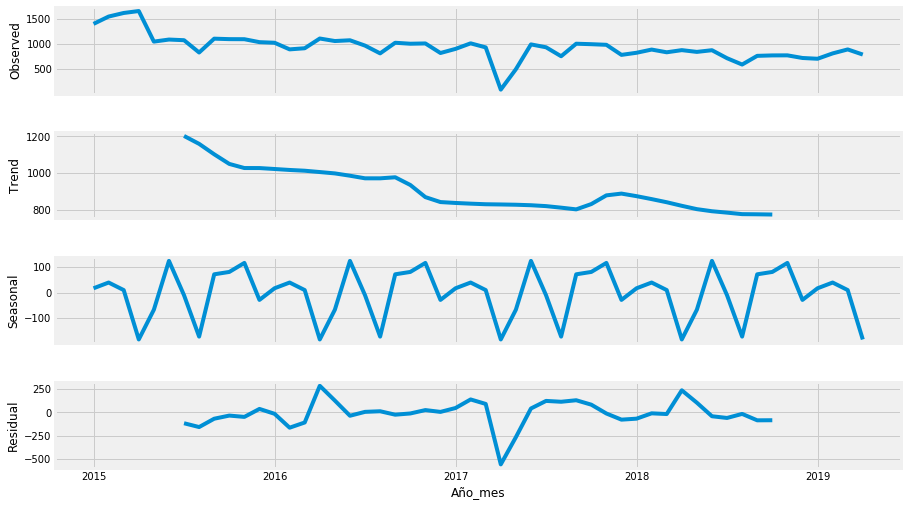

In [355]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_princesa_NS, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [356]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_princesa_NS, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# We can confirm the serie is stationary since the obtained p-value < 0.05

Test statistic: -3.36513556160524
p-value: 0.01220639394358148
Lag: 2
Number of observations: 49
Critical Value (1%) = -3.5714715250448363
Critical Value (5%) = -2.922629480573571
Critical Value (10%) = -2.5993358475635153


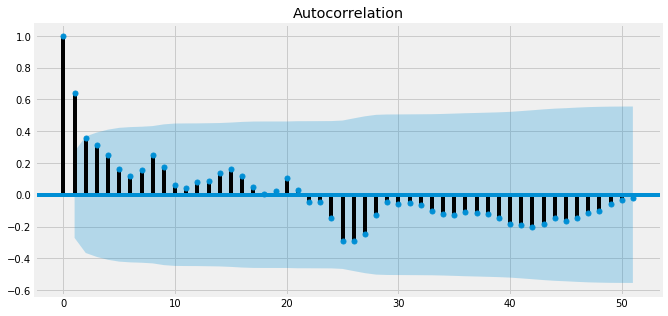

In [357]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_princesa_NS)
fig.set_size_inches(10,5)

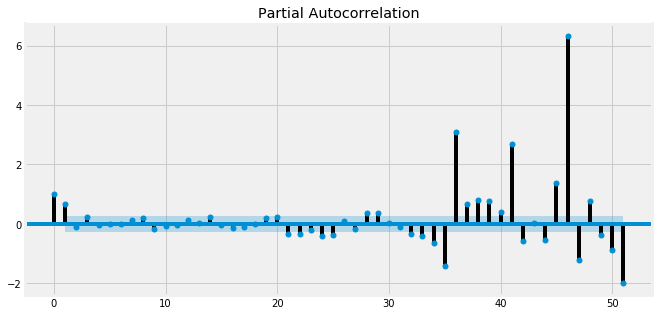

In [358]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_princesa_NS)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [359]:
len(series_princesa_NS)

52

In [360]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_princesa_NS = series_princesa_NS.loc['2015-01-31':'2018-12-31']
test_princesa_NS = series_princesa_NS.loc['2019-01-01':'2019-04-30']

In [361]:
len(train_princesa_NS), len(test_princesa_NS)

(48, 4)

In [362]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_princesa_NS, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_princesa_NS['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:800.1257721669967 - p-values:sigma2    0.064303
dtype: float64
The Mean Squared Error of our forecasts is 646264.13
The Root Mean Squared Error of our forecasts is 803.91
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:521.1300067015553 - p-values:sigma2    9.556751e-10
dtype: float64
The Mean Squared Error of our forecasts is 7783.12
The Root Mean Squared Error of our forecasts is 88.22
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:722.9942170389843 - p-values:ar.S.L12    2.338714e-202
sigma2       1.300323e-08
dtype: float64
The Mean Squared Error of our forecasts is 4700.54
The Root Mean Squared Error of our forecasts is 68.56
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:520.818267659139 - p-values:ar.S.L12    2.630040e-02
sigma2      1.543339e-10
dtype: float64
The Mean Squared Error of our forecasts is 12919.58
The Root Mean Squared Error of our forecasts is 113.66
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:750.5641118061666 - p-values:ma.L1     1.094882e-16
sigma2    1.456573e

In [363]:
# We select the model SARIMAX(0, 1, 0)x(0, 1, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_princesa_NS,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -250.044
Date:                            Thu, 16 May 2019   AIC                            502.088
Time:                                    12:03:03   BIC                            503.643
Sample:                                01-31-2015   HQIC                           502.625
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.373e+04   1.33e+04      7.046      0.000    6.77e+04     1.2e+05
Ljung-Box (Q):                     

In [364]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([ 1.40230312e+03,  1.46252374e+02,  7.13743699e+01,  3.86958494e+01,
       -6.09411121e+02,  4.08369401e+01, -1.31279420e+01, -2.44941031e+02,
        2.75573916e+02, -9.31873225e+00, -1.32913723e+00, -5.87910462e+01,
       -7.44493185e+02, -2.78155636e+02, -4.91741768e+01,  1.55417589e+02,
        5.59342809e+02, -2.57604955e+01, -9.31811929e+01,  9.01361090e+01,
       -6.38582584e+01, -1.01900924e+01,  7.00778806e+00, -1.31743759e+02,
        9.40748672e+01,  2.42382101e+02, -1.02878026e+02, -1.03598410e+03,
        4.56030976e+02,  4.80514235e+02,  4.88084799e+01, -2.38536278e+01,
        3.79975505e+01,  9.99080566e+00, -1.79413103e+01, -1.00596105e+01,
       -4.01895326e+01, -4.68140903e+01,  2.66762369e+01,  8.84658537e+02,
       -4.41056321e+02, -4.61939669e+02, -1.02308677e+02,  5.26943719e+01,
       -7.65171486e+01,  1.83303529e+01,  1.35685034e+01,  1.48051637e+02])

In [365]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.734 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution


from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.1962876823335833, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [366]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 0.03626905,  2.06545193,  2.160707  ,  4.17245684,  4.17368568,
         4.17380583,  4.35455997,  5.73068571,  5.8868326 ,  6.18620597,
         6.93963514, 20.67526743]),
 array([0.84896095, 0.3560351 , 0.53972928, 0.38316919, 0.52469025,
        0.65316884, 0.73815245, 0.67736966, 0.751189  , 0.79938386,
        0.80395068, 0.05534271]),
 array([ 0.03409291,  1.90094116,  1.98667072,  3.75701058,  3.75806738,
         3.75816831,  3.90638671,  5.0072873 ,  5.12908187,  5.35660563,
         5.91414321, 15.80379847]),
 array([0.85350934, 0.38655907, 0.57517785, 0.43988844, 0.58474688,
        0.7093637 , 0.79049455, 0.75679697, 0.82291376, 0.8661198 ,
        0.87903096, 0.20038863]))

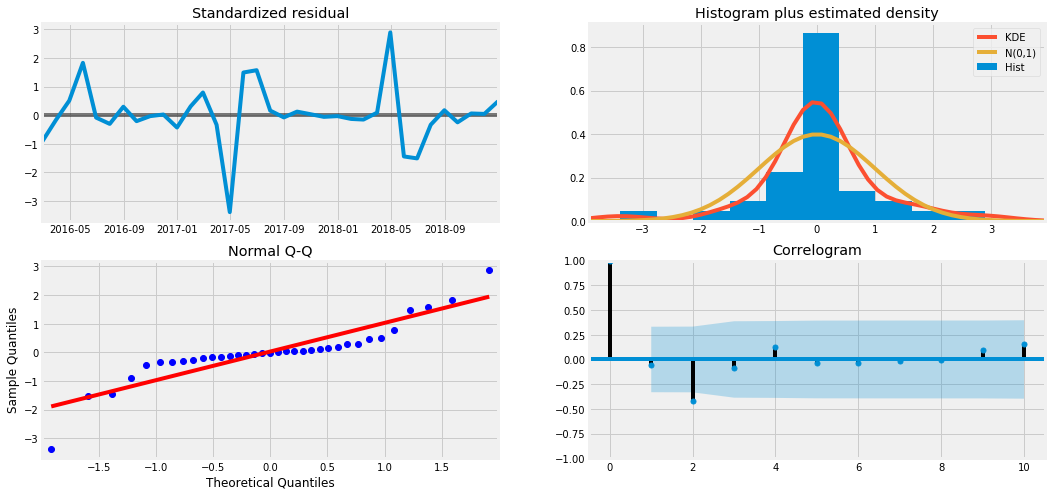

In [367]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

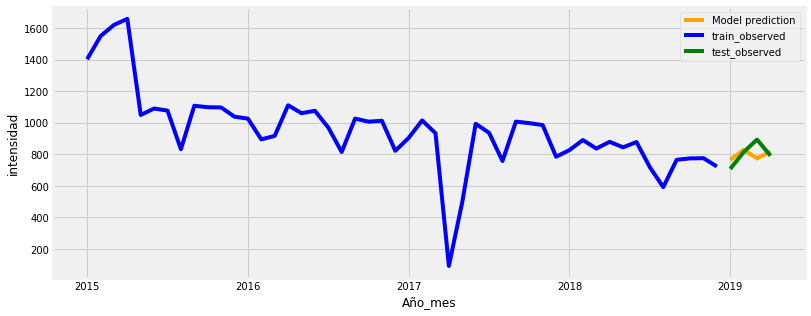

In [368]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_princesa_NS.plot(color = 'blue', label = 'train_observed')
test_princesa_NS.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [369]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    764.471540
2019-02-28    828.136288
2019-03-31    774.134692
2019-04-30    816.922563
Freq: M, dtype: float64

In [370]:
# Test values to compare vs forecasted values

y_truth = test_princesa_NS['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    707.035255
2019-02-28    813.761123
2019-03-31    893.070431
2019-04-30    790.807009
Freq: M, Name: intensidad, dtype: float64

In [371]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_princesa_NS['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 4583.33
The Root Mean Squared Error of our forecasts is 67.7


## Applying the model

In [372]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(series_princesa_NS,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -276.769
Date:                            Thu, 16 May 2019   AIC                            555.538
Time:                                    12:03:04   BIC                            557.202
Sample:                                01-31-2015   HQIC                           556.135
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.531e+04   1.09e+04      7.797      0.000    6.39e+04    1.07e+05
Ljung-Box (Q):                     

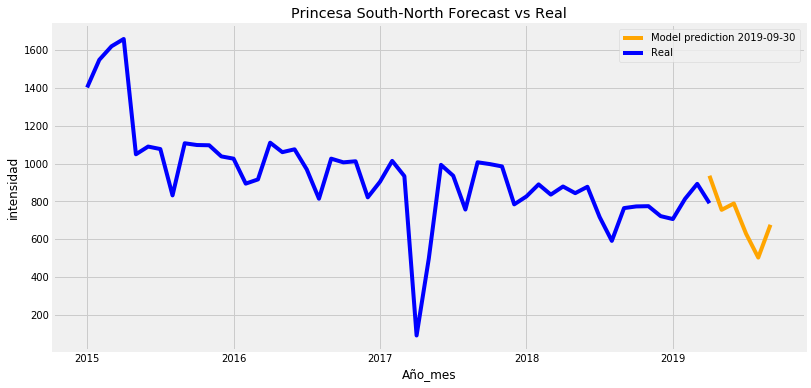

In [374]:
# Plot to forecast

plt.figure(figsize=(12,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_princesa_NS.plot(color = 'blue', label='Real')

plt.title('Princesa South-North Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

## Focus on GRAN VIA South-North

In [400]:
# For this time it is not necessary to split the dataframe

granvia_SN = final_data[final_data['id'] == 4305]

In [401]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

granvia_SN = granvia_SN.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
granvia_SN = granvia_SN.set_index(granvia_SN['Año_mes'])
granvia_SN.index = pd.to_datetime(granvia_SN.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_granvia_SN = granvia_SN['intensidad'].resample('M').mean()

In [402]:
series_granvia_SN.tail()

Año_mes
2018-12-31    131.761385
2019-01-31    120.834915
2019-02-28    138.618697
2019-03-31    140.950000
2019-04-30    130.873282
Freq: M, Name: intensidad, dtype: float64

Text(0.5, 1.0, 'Time Series Gran Via South-North')

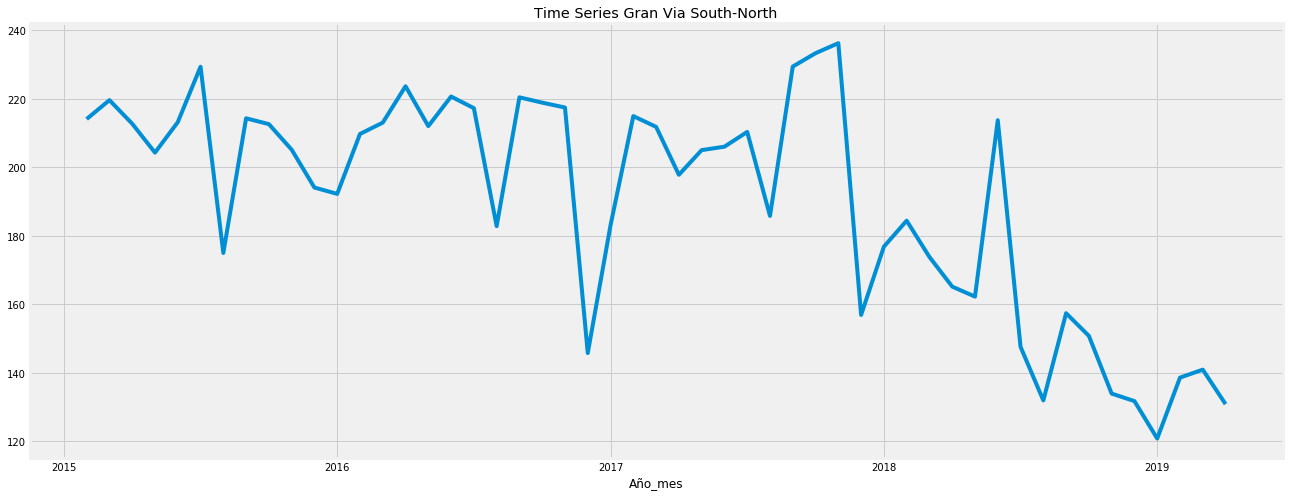

In [403]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_granvia_SN.plot()
plt.title('Time Series Gran Via South-North')

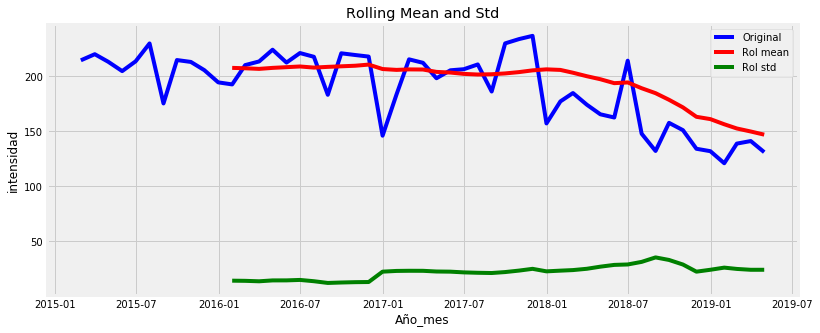

In [404]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_granvia_SN = series_granvia_SN.rolling(12).mean()
rolstd_granvia_SN = series_granvia_SN.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_granvia_SN, label = 'Original', color = 'blue')
plt.plot(rolmean_granvia_SN, label = 'Rol mean', color = 'red')
plt.plot(rolstd_granvia_SN, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

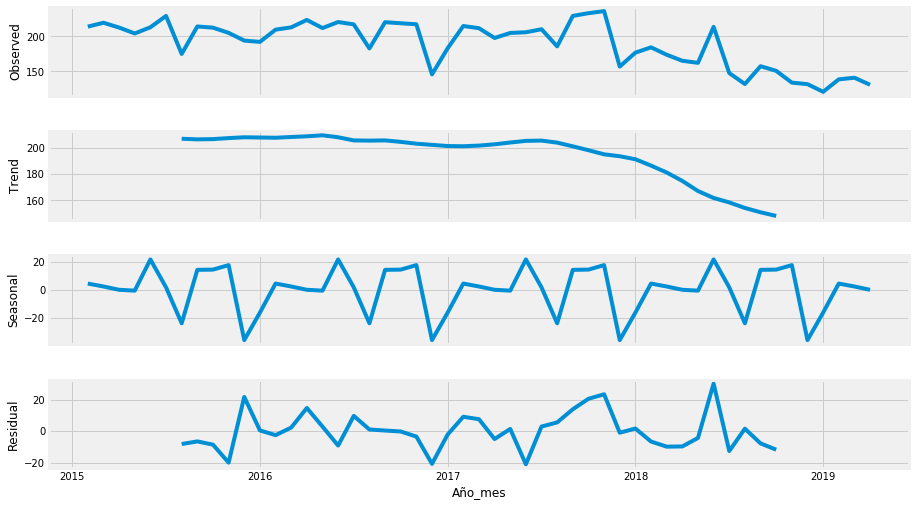

In [405]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_granvia_SN, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [406]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_granvia_SN, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# Non-Stationary since the p-value > 0.05, let see the diff()

Test statistic: -0.059830297080479496
p-value: 0.9532954960316874
Lag: 3
Number of observations: 47
Critical Value (1%) = -3.5778480370438146
Critical Value (5%) = -2.925338105429433
Critical Value (10%) = -2.6007735310095064


In [407]:
series_granvia_SN_diff = series_granvia_SN.diff()
series_granvia_SN_diff = series_granvia_SN_diff[1:]

In [408]:
# Recompute the adfuller test and we see that with 1 diff the serie is stationary  (p-value < 0.05) 
# so in our model we need to apply 1 diff

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_granvia_SN_diff, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# Now it is stationary with 1 diff

Test statistic: -7.948491296741194
p-value: 3.1723499981429366e-12
Lag: 2
Number of observations: 47
Critical Value (1%) = -3.5778480370438146
Critical Value (5%) = -2.925338105429433
Critical Value (10%) = -2.6007735310095064


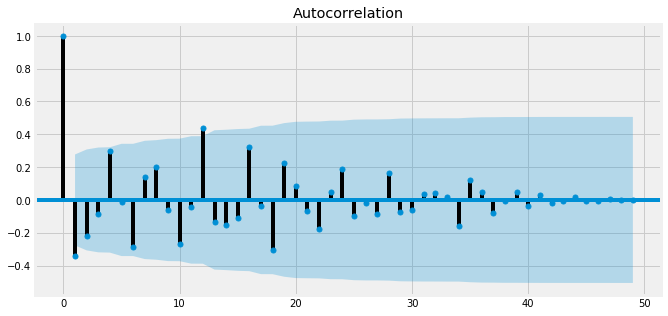

In [409]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_granvia_SN_diff)
fig.set_size_inches(10,5)

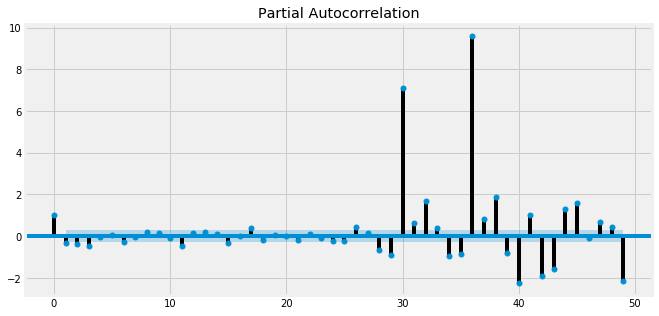

In [410]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_granvia_SN_diff)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [411]:
len(series_granvia_SN)

51

In [412]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_granvia_SN = series_granvia_SN.loc['2015-01-31':'2018-12-31']
test_granvia_SN = series_granvia_SN.loc['2019-01-01':'2019-04-30']

In [413]:
len(train_granvia_SN), len(test_granvia_SN)

(47, 4)

In [414]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_granvia_SN, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_granvia_SN['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:632.103694207284 - p-values:sigma2    0.34962
dtype: float64
The Mean Squared Error of our forecasts is 17702.73
The Root Mean Squared Error of our forecasts is 133.05
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:347.9854026448371 - p-values:sigma2    9.135968e-09
dtype: float64
The Mean Squared Error of our forecasts is 1874.66
The Root Mean Squared Error of our forecasts is 43.3
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:509.2748926742521 - p-values:ar.S.L12    0.000000
sigma2      0.000015
dtype: float64
The Mean Squared Error of our forecasts is 1639.08
The Root Mean Squared Error of our forecasts is 40.49
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:511.0914214953373 - p-values:ar.S.L12    4.624313e-303
ma.S.L12     8.333152e-01
sigma2       6.662408e-04
dtype: float64
The Mean Squared Error of our forecasts is 1949.14
The Root Mean Squared Error of our forecasts is 44.15
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:349.3665410612398 - p-values:ar.S.L12    0.736861
sigma2  

In [415]:
# We select the model SARIMAX(1, 1, 0)x(1, 0, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_granvia_SN,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   47
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -206.947
Date:                            Thu, 16 May 2019   AIC                            419.894
Time:                                    12:07:38   BIC                            425.380
Sample:                                02-28-2015   HQIC                           421.949
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3987      0.119     -3.347      0.001      -0.632      -0.165
ar.S.L12       0.5654      0.105   

In [416]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([ 2.14116841e+02,  5.58446027e+00, -4.68051741e+00, -1.11796700e+01,
        5.51532827e+00,  1.97282200e+01, -4.79105364e+01,  1.76298620e+01,
        1.39969870e+01, -8.19592863e+00, -1.38734880e+01, -6.62493394e+00,
        1.77783095e+01,  5.52688023e+00,  1.45851282e+01, -1.08404751e+00,
        8.83787136e-01, -1.11140461e+01, -8.70346264e+00,  1.39016751e+01,
        5.53834021e+00,  2.56147046e+00, -6.43248825e+01,  1.22809765e+01,
        3.72697200e+01,  3.74626010e+00, -2.19955746e+01,  5.80900187e+00,
        1.60984142e+00,  4.68609758e+00, -2.56758109e+00,  2.03295216e+01,
        1.36921433e+01,  5.63071464e+00, -3.73345338e+01, -1.66380281e+01,
       -1.08905495e+01, -1.29738747e+01, -4.26060119e+00, -7.28640259e+00,
        4.81432442e+01, -4.82944824e+01, -2.91342705e+01,  9.61236062e-02,
       -8.50396297e+00, -2.20226774e+01,  3.52973462e+01])

In [417]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.733 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.715102113640654, critical_values=array([0.536, 0.611, 0.733, 0.855, 1.017]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [418]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them


(array([0.01276426, 0.51197522, 0.58227659, 0.79366314, 0.83092755,
        2.35683077, 2.93635539, 3.3218617 , 3.40814207, 4.20902747,
        4.23629213, 4.7424634 ]),
 array([0.9100472 , 0.77415156, 0.90047748, 0.93929559, 0.97501889,
        0.88413391, 0.89082677, 0.91256685, 0.94589722, 0.93742507,
        0.96248806, 0.96603232]),
 array([0.01198277, 0.47044182, 0.53356958, 0.71907206, 0.75101298,
        2.02778915, 2.50087047, 2.80770202, 2.87461333, 3.47936354,
        3.49939471, 3.86094562]),
 array([0.91283301, 0.79039622, 0.91145679, 0.94895629, 0.98005211,
        0.91712517, 0.9270315 , 0.94583949, 0.96905914, 0.96779443,
        0.98234757, 0.9858168 ]))

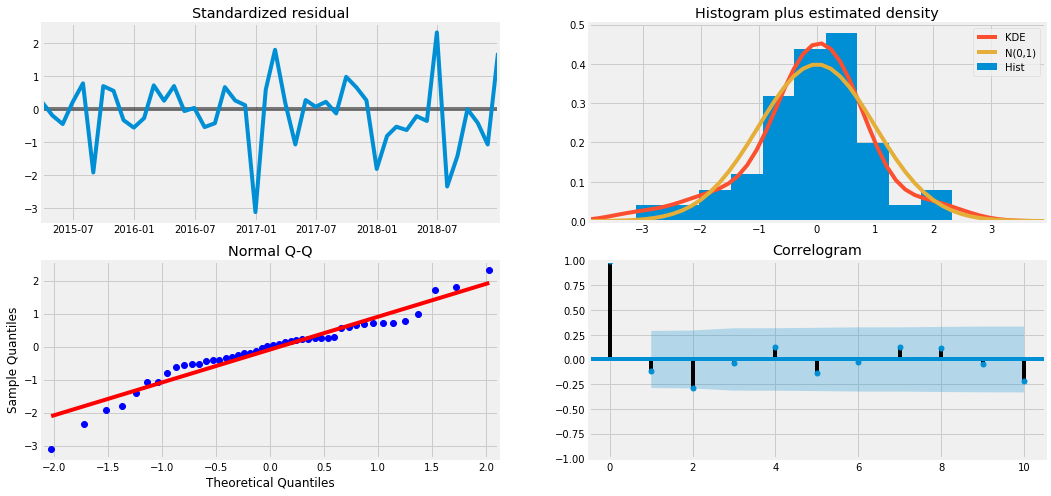

In [419]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

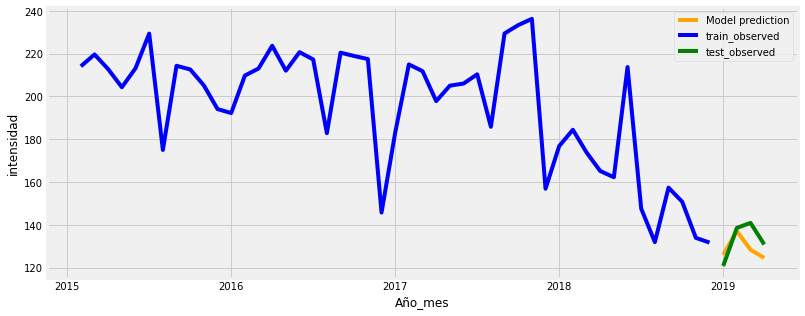

In [420]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_granvia_SN.plot(color = 'blue', label = 'train_observed')
test_granvia_SN.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [421]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    126.021842
2019-02-28    137.095218
2019-03-31    128.401858
2019-04-30    124.585775
Freq: M, dtype: float64

In [422]:
# Test values to compare vs forecasted values

y_truth = test_granvia_SN['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    120.834915
2019-02-28    138.618697
2019-03-31    140.950000
2019-04-30    130.873282
Freq: M, Name: intensidad, dtype: float64

In [423]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_granvia_SN['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 56.55
The Root Mean Squared Error of our forecasts is 7.52


## Applying the model

In [424]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(series_granvia_SN,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   51
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -222.946
Date:                            Thu, 16 May 2019   AIC                            451.892
Time:                                    12:07:44   BIC                            457.628
Sample:                                02-28-2015   HQIC                           454.077
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4072      0.110     -3.712      0.000      -0.622      -0.192
ar.S.L12       0.5773      0.097   

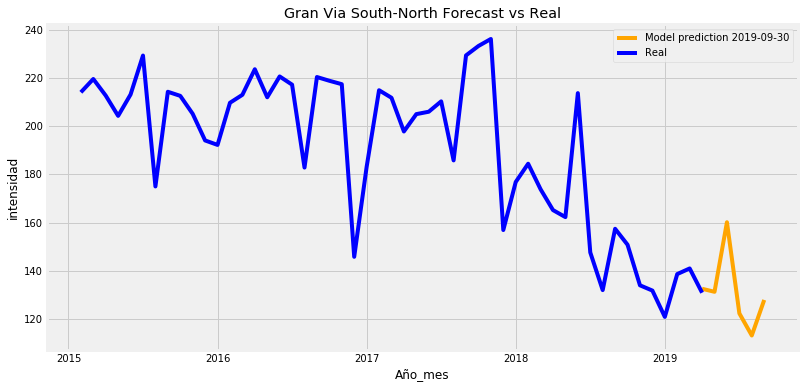

In [426]:
# Plot to forecast

plt.figure(figsize=(12,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_granvia_SN.plot(color = 'blue', label='Real')

plt.title('Gran Via South-North Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

## Focus on PASEO DEL PRADO North-South

In [427]:
# For this time it is not necessary to split the dataframe

prado_NS = final_data[final_data['id'] == 7139]

In [428]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

prado_NS = prado_NS.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
prado_NS = prado_NS.set_index(prado_NS['Año_mes'])
prado_NS.index = pd.to_datetime(prado_NS.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_prado_NS = prado_NS['intensidad'].resample('M').mean()

In [429]:
series_prado_NS.tail()

Año_mes
2018-12-31    1887.602467
2019-01-31    1730.001423
2019-02-28    1962.099474
2019-03-31    1966.751328
2019-04-30    1854.837481
Freq: M, Name: intensidad, dtype: float64

Text(0.5, 1.0, 'Time Series Prado North-South')

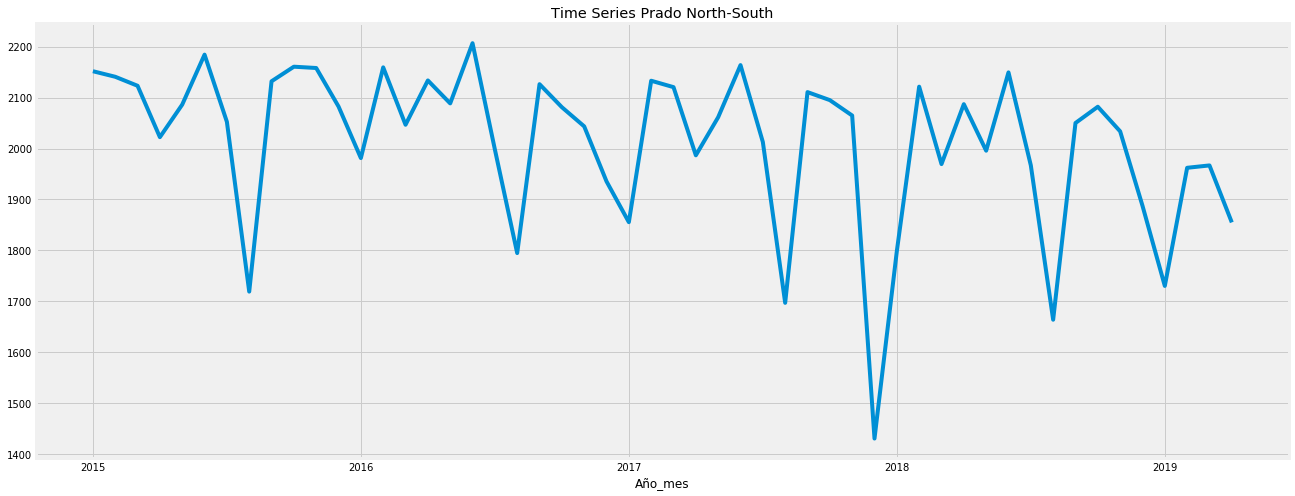

In [430]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_prado_NS.plot()
plt.title('Time Series Prado North-South')

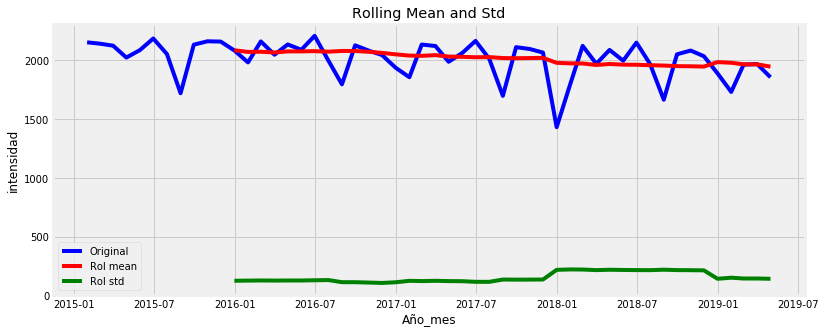

In [431]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_prado_NS = series_prado_NS.rolling(12).mean()
rolstd_prado_NS = series_prado_NS.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_prado_NS, label = 'Original', color = 'blue')
plt.plot(rolmean_prado_NS, label = 'Rol mean', color = 'red')
plt.plot(rolstd_prado_NS, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

# they look stable during the time so it appears to be stationary but let's continue with the process to be 100% sure

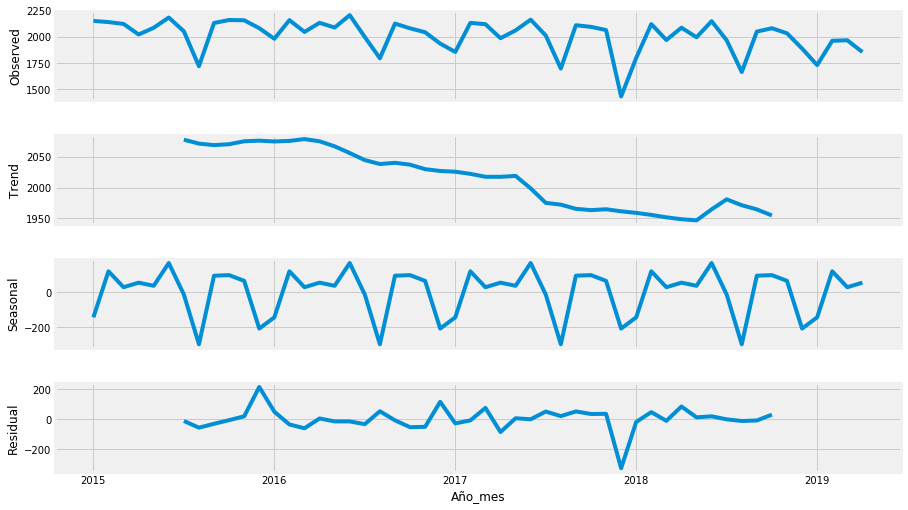

In [432]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_prado_NS, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [433]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_prado_NS, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# the serie is not stationary since the obtained p-value > 0.05, let's differenciate the serie

Test statistic: -0.7030227062407977
p-value: 0.8459650344668925
Lag: 11
Number of observations: 40
Critical Value (1%) = -3.6055648906249997
Critical Value (5%) = -2.937069375
Critical Value (10%) = -2.606985625


In [434]:
series_prado_NS_diff = series_prado_NS.diff()
series_prado_NS_diff = series_prado_NS_diff[1:]

In [435]:
# now it is stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_prado_NS_diff, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

Test statistic: -4.286396896269033
p-value: 0.00046893353859122483
Lag: 10
Number of observations: 40
Critical Value (1%) = -3.6055648906249997
Critical Value (5%) = -2.937069375
Critical Value (10%) = -2.606985625


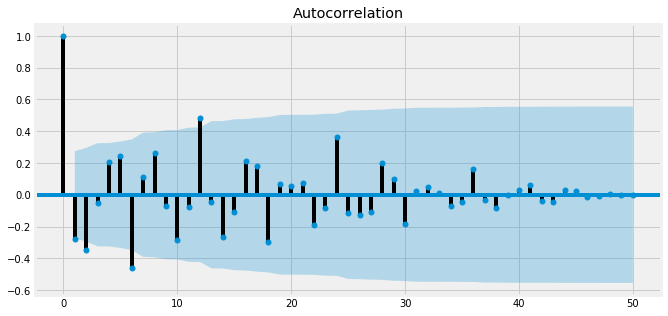

In [436]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_prado_NS_diff)
fig.set_size_inches(10,5)

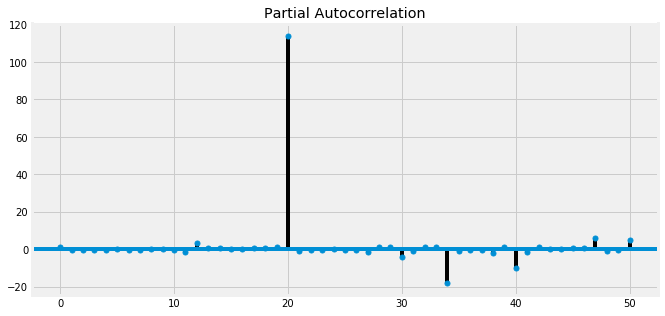

In [437]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_prado_NS_diff)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [438]:
len(series_prado_NS)

52

In [439]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_prado_NS = series_prado_NS.loc['2015-01-31':'2018-12-31']
test_prado_NS = series_prado_NS.loc['2019-01-01':'2019-04-30']

In [440]:
len(train_prado_NS), len(test_prado_NS)

(48, 4)

In [441]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_prado_NS, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_prado_NS['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:869.3228610906494 - p-values:sigma2    0.623304
dtype: float64
The Mean Squared Error of our forecasts is 3537818.03
The Root Mean Squared Error of our forecasts is 1880.91
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:457.9935038144111 - p-values:sigma2    1.662020e-17
dtype: float64
The Mean Squared Error of our forecasts is 21004.67
The Root Mean Squared Error of our forecasts is 144.93
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:676.8895823568563 - p-values:ar.S.L12    0.000000e+00
sigma2      3.342460e-17
dtype: float64
The Mean Squared Error of our forecasts is 19963.11
The Root Mean Squared Error of our forecasts is 141.29
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:455.7762790707776 - p-values:ar.S.L12    2.983767e-04
sigma2      1.606367e-20
dtype: float64
The Mean Squared Error of our forecasts is 19081.92
The Root Mean Squared Error of our forecasts is 138.14
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:812.6538616019286 - p-values:ma.L1     0.0713
sigma2    0.0000
dty

In [442]:
# We select the model SARIMAX(0, 1, 0)x(0, 0, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_prado_NS,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -317.659
Date:                Thu, 16 May 2019   AIC                            637.317
Time:                        12:10:52   BIC                            639.167
Sample:                    01-31-2015   HQIC                           638.013
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.344e+04   7672.805      5.662      0.000    2.84e+04    5.85e+04
Ljung-Box (Q):                      112.35   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.00   Pr

In [443]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([2151.8255287 ,  -10.92164215,  -17.68868465, -100.93147865,
         63.96327915,   98.13067256, -131.93136623, -333.54999423,
        413.14905292,   28.64500296,   -2.56979924,  -75.66870852,
       -101.25783983,  178.21059261, -112.76153846,   87.05669563,
        -45.11006597,  118.28324626, -208.65562399, -203.61701943,
        331.73895861,  -45.19367418,  -37.66711539, -108.0999206 ,
        -80.10218343,  277.83129362,  -12.58673562, -133.88842013,
         74.85701149,  102.32901469, -151.08753038, -315.87996448,
        413.93718001,  -15.75969298,  -30.25332162, -634.49523303,
        368.07702692,  323.1477389 , -152.13004479,  117.68958166,
        -91.34903422,  153.8117163 , -182.65148369, -303.20041772,
        386.40695643,   31.93648514,  -48.34154016, -146.07449399])

In [444]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.734 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.702114667649198, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [445]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([0.42714413, 1.06169351, 1.19851417, 1.67728845, 2.12545533,
        4.09804963, 4.29626253, 6.77540969, 6.78497076, 7.42416195,
        7.52202571, 8.55331905]),
 array([0.51339362, 0.58810678, 0.7533607 , 0.79483895, 0.83152773,
        0.66340947, 0.74509115, 0.56104691, 0.65949569, 0.68488581,
        0.75537171, 0.7405348 ]),
 array([0.40151548, 0.98530091, 1.10843951, 1.52976087, 1.91518439,
        3.5721636 , 3.73469818, 5.71801591, 5.72547354, 6.21125885,
        6.28367803, 7.02620923]),
 array([0.52630764, 0.6110048 , 0.77503715, 0.82135695, 0.86075205,
        0.7343452 , 0.80977751, 0.67878431, 0.76704851, 0.79721281,
        0.85378173, 0.85587668]))

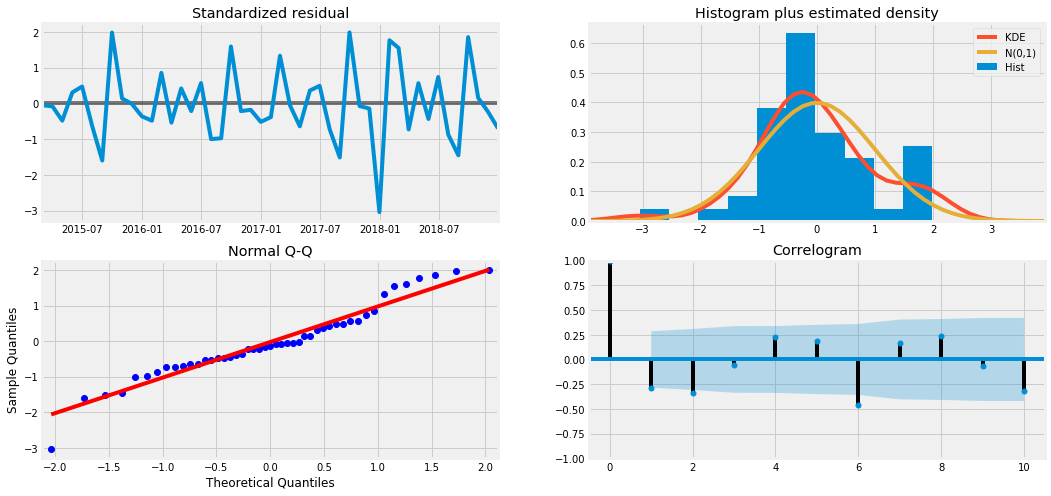

In [446]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

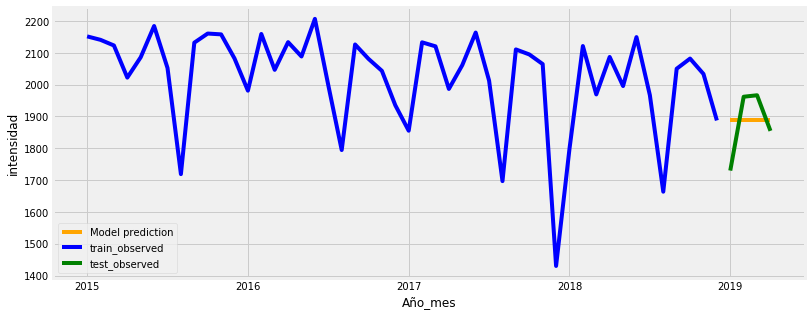

In [447]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_prado_NS.plot(color = 'blue', label = 'train_observed')
test_prado_NS.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [448]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    1887.602467
2019-02-28    1887.602467
2019-03-31    1887.602467
2019-04-30    1887.602467
Freq: M, dtype: float64

In [449]:
# Test values to compare vs forecasted values

y_truth = test_prado_NS['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    1730.001423
2019-02-28    1962.099474
2019-03-31    1966.751328
2019-04-30    1854.837481
Freq: M, Name: intensidad, dtype: float64

In [450]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_prado_NS['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 9431.49
The Root Mean Squared Error of our forecasts is 97.12


## Applying the model

In [451]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(series_prado_NS,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -343.725
Date:                Thu, 16 May 2019   AIC                            689.450
Time:                        12:10:53   BIC                            691.382
Sample:                    01-31-2015   HQIC                           690.188
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.183e+04   7066.608      5.919      0.000     2.8e+04    5.57e+04
Ljung-Box (Q):                      118.26   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.00   Pr

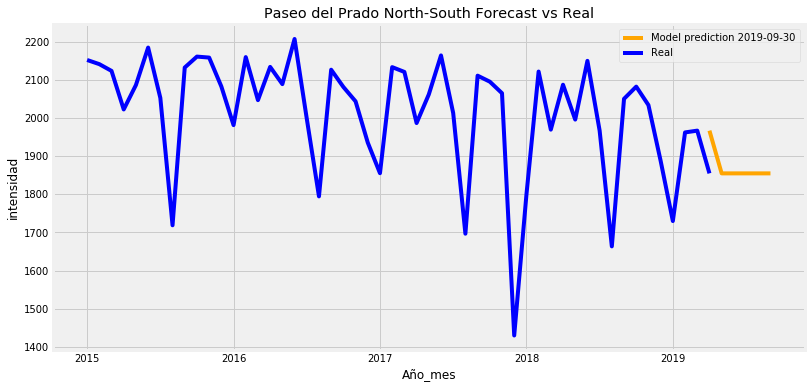

In [454]:
# Plot to forecast

plt.figure(figsize=(12,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_prado_NS.plot(color = 'blue', label='Real')

plt.title('Paseo del Prado North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

## Focus on RONDA DE VALENCIA West-East

In [455]:
# For this time it is not necessary to split the dataframe

valencia_WE = final_data[final_data['id'] == 4211]

In [456]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

valencia_WE = valencia_WE.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
valencia_WE = valencia_WE.set_index(valencia_WE['Año_mes'])
valencia_WE.index = pd.to_datetime(valencia_WE.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_valencia_WE = valencia_WE['intensidad'].resample('M').mean()

In [457]:
series_valencia_WE.tail(20)

Año_mes
2017-09-30    918.599020
2017-10-31    937.925820
2017-11-30    947.324828
2017-12-31    957.180704
2018-01-31    939.095825
2018-02-28    999.518677
2018-03-31    937.175734
2018-04-30    981.950197
2018-05-31    976.520803
2018-06-30    997.368627
2018-07-31    866.789499
2018-08-31    717.215370
2018-09-30    925.695588
2018-10-31    975.490692
2018-11-30    954.412255
2018-12-31    903.416983
2019-01-31    844.996671
2019-02-28    932.927971
2019-03-31    887.583771
2019-04-30    850.281711
Freq: M, Name: intensidad, dtype: float64

Text(0.5, 1.0, 'Time Series Ronda de Valencia West-East')

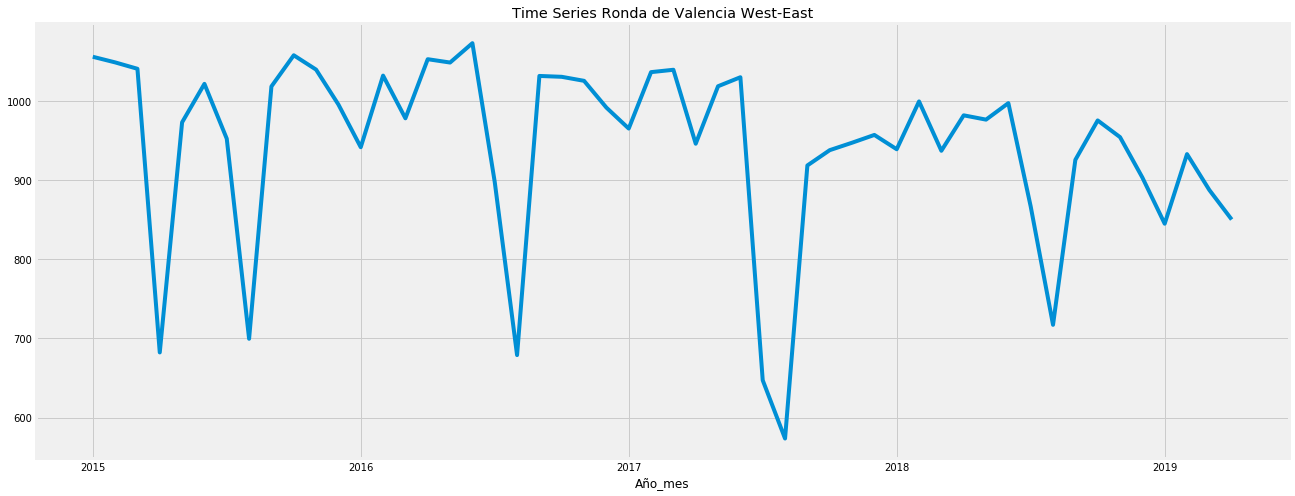

In [458]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_valencia_WE.plot()
plt.title('Time Series Ronda de Valencia West-East')

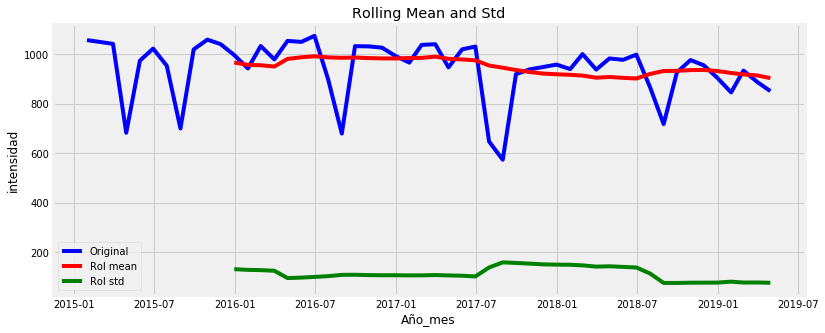

In [459]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_valencia_WE = series_valencia_WE.rolling(12).mean()
rolstd_valencia_WE = series_valencia_WE.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_valencia_WE, label = 'Original', color = 'blue')
plt.plot(rolmean_valencia_WE, label = 'Rol mean', color = 'red')
plt.plot(rolstd_valencia_WE, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

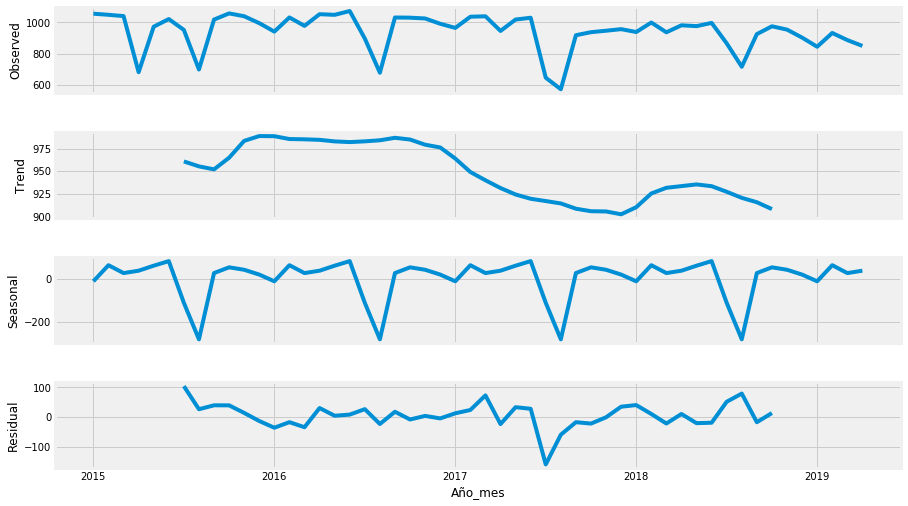

In [460]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_valencia_WE, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [461]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_valencia_WE, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# the serie is not stationary since the obtained p-value > 0.05, we apply diff

Test statistic: -0.4479325207937122
p-value: 0.9017829357990061
Lag: 11
Number of observations: 40
Critical Value (1%) = -3.6055648906249997
Critical Value (5%) = -2.937069375
Critical Value (10%) = -2.606985625


In [462]:
series_valencia_WE_diff = series_valencia_WE.diff()
series_valencia_WE_diff = series_valencia_WE_diff[1:]

In [463]:
# It is stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_valencia_WE_diff, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))

Test statistic: -5.673003400889564
p-value: 8.833791110279122e-07
Lag: 10
Number of observations: 40
Critical Value (1%) = -3.6055648906249997
Critical Value (5%) = -2.937069375
Critical Value (10%) = -2.606985625


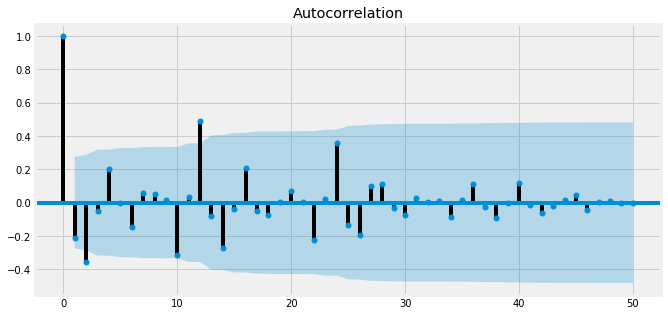

In [464]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_valencia_WE_diff)
fig.set_size_inches(10,5)

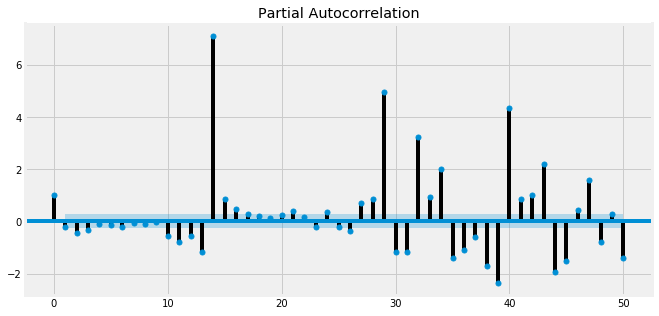

In [465]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_valencia_WE_diff)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [466]:
len(series_valencia_WE)

52

In [467]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_valencia_WE = series_valencia_WE.loc['2015-01-31':'2018-12-31']
test_valencia_WE = series_valencia_WE.loc['2019-01-01':'2019-04-30']

In [468]:
len(train_valencia_WE), len(test_valencia_WE)

(48, 4)

In [469]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_valencia_WE, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_valencia_WE['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:797.0942168520198 - p-values:sigma2    0.446648
dtype: float64
The Mean Squared Error of our forecasts is 773789.48
The Root Mean Squared Error of our forecasts is 879.65
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:437.53721739561246 - p-values:sigma2    9.723795e-13
dtype: float64
The Mean Squared Error of our forecasts is 8271.23
The Root Mean Squared Error of our forecasts is 90.95
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:638.1498020185368 - p-values:ar.S.L12    0.000000e+00
sigma2      2.518352e-12
dtype: float64
The Mean Squared Error of our forecasts is 7347.87
The Root Mean Squared Error of our forecasts is 85.72
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:434.04612696669875 - p-values:ar.S.L12    1.772072e-03
sigma2      4.919861e-10
dtype: float64
The Mean Squared Error of our forecasts is 10190.68
The Root Mean Squared Error of our forecasts is 100.95
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.7131270664405 - p-values:ma.L1     3.048723e-21
sigma2    3.338914

In [470]:
# We select the model SARIMAX(0, 1, 0)x(1, 1, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_valencia_WE,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -214.071
Date:                            Thu, 16 May 2019   AIC                            432.142
Time:                                    12:14:24   BIC                            435.253
Sample:                                01-31-2015   HQIC                           433.216
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5841      0.110     -5.315      0.000      -0.799      -0.369
sigma2      1.052e+04   2008.686   

In [471]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([1055.95694864,   -7.08859688,   -8.10106252, -358.43519179,
        290.749441  ,   48.62455053,  -69.27174556, -252.8477747 ,
        318.85312495,   39.39813091,  -18.09976685,  -44.13960588,
       -581.21230529,   97.50532648,  -45.9224024 ,  429.83865656,
       -292.30043756,  -23.72929247, -106.79022652,   31.81313123,
         36.81299732,  -40.12628841,   12.85151216,    9.91418696,
         17.09020845,   37.80894046,   30.15165214,   84.85270439,
        -95.44707374,  -27.18099786, -269.46286741,  164.97048692,
         12.12929206,   -3.23311513,   22.08496625,   49.70386595,
         24.43532295,  -22.08080947,  -32.07099119,   40.00998607,
        -33.17028444,    1.83011048,  131.12459298,    8.82344831,
       -141.07203833,   42.39395405,  -22.01875921,  -35.33913676])

In [472]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.734 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=4.051401327704717, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [473]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 1.25447822,  1.25474448,  7.59685278, 10.00056882, 10.19591449,
        10.20697508, 10.50792387, 10.51578135, 11.68260831, 11.70024249,
        11.90340399, 19.5898333 ]),
 array([0.26269888, 0.53399317, 0.05512142, 0.0404181 , 0.06987064,
        0.11620212, 0.16156982, 0.23067282, 0.23179939, 0.30561898,
        0.3709477 , 0.07525373]),
 array([ 1.17920953,  1.17945448,  6.88735196,  9.00262207,  9.17061934,
         9.17991025,  9.42668825,  9.43297424, 10.34309927, 10.35650124,
        10.50684075, 16.04106985]),
 array([0.27751698, 0.5544785 , 0.07557625, 0.06103398, 0.10244921,
        0.16371   , 0.22345519, 0.30709652, 0.32342998, 0.4097924 ,
        0.48545309, 0.18936222]))

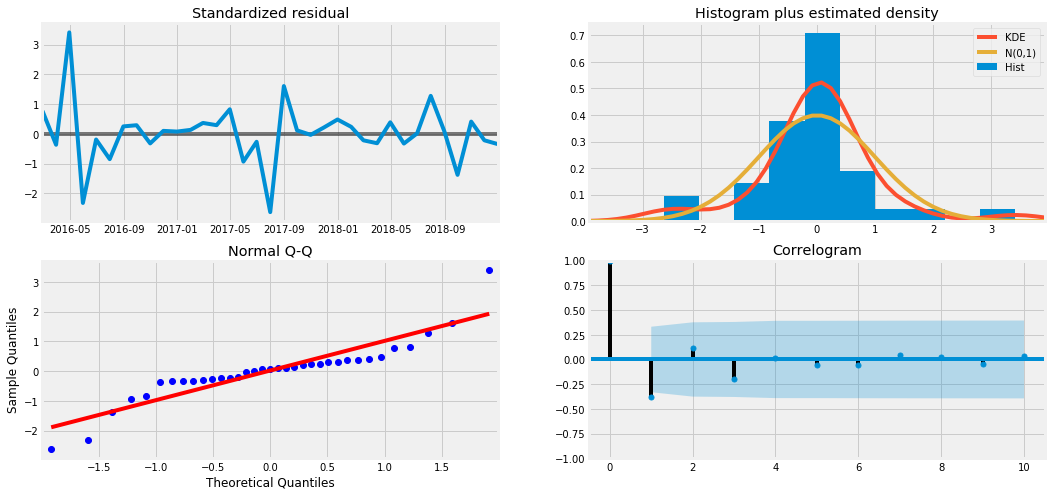

In [474]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

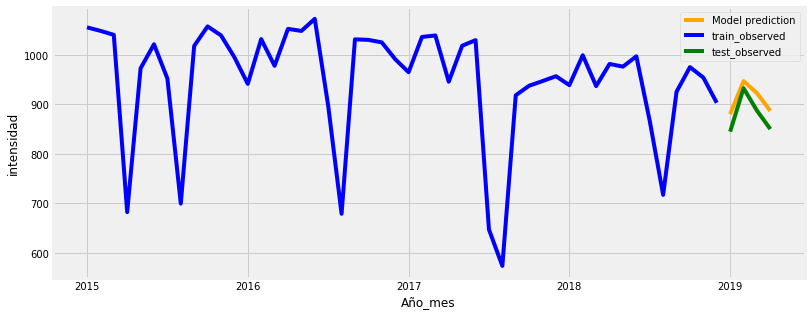

In [475]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_valencia_WE.plot(color = 'blue', label = 'train_observed')
test_valencia_WE.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [476]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    880.425556
2019-02-28    947.200884
2019-03-31    923.016037
2019-04-30    887.050161
Freq: M, dtype: float64

In [477]:
# Test values to compare vs forecasted values

y_truth = test_valencia_WE['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    844.996671
2019-02-28    932.927971
2019-03-31    887.583771
2019-04-30    850.281711
Freq: M, Name: intensidad, dtype: float64

In [478]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_valencia_WE['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1016.57
The Root Mean Squared Error of our forecasts is 31.88


## Applying the model

In [479]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(series_valencia_WE,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -236.259
Date:                            Thu, 16 May 2019   AIC                            476.519
Time:                                    12:14:38   BIC                            479.846
Sample:                                01-31-2015   HQIC                           477.713
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6070      0.091     -6.679      0.000      -0.785      -0.429
sigma2      9361.8617   1575.180   

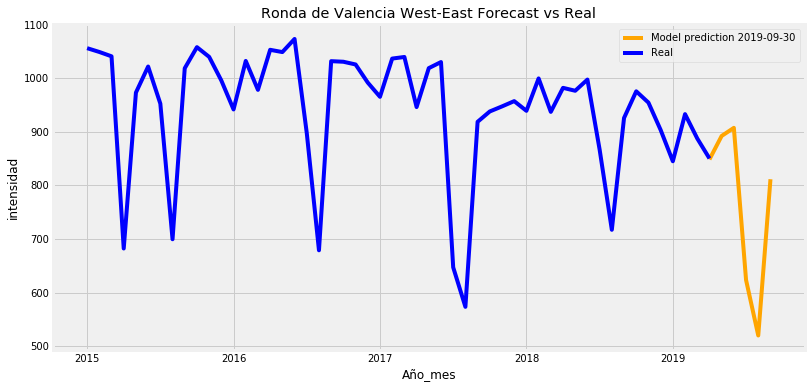

In [481]:
# Plot to forecast

plt.figure(figsize=(12,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_valencia_WE.plot(color = 'blue', label='Real')

plt.title('Ronda de Valencia West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

## Focus on ALBERTO AGUILERA West-East

In [482]:
# For this time it is not necessary to split the dataframe

aguilera_WE = final_data[final_data['id'] == 4386]

In [483]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

aguilera_WE = aguilera_WE.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
aguilera_WE = aguilera_WE.set_index(aguilera_WE['Año_mes'])
aguilera_WE.index = pd.to_datetime(aguilera_WE.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_aguilera_WE = aguilera_WE['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Time Series Alberto Aguilera West-East')

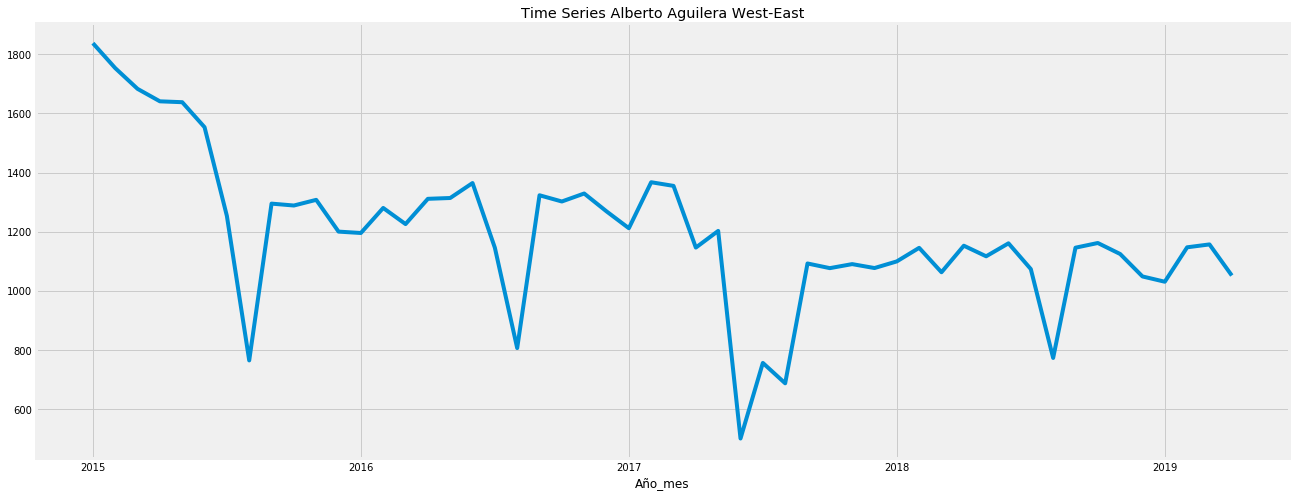

In [484]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_aguilera_WE.plot()
plt.title('Time Series Alberto Aguilera West-East')

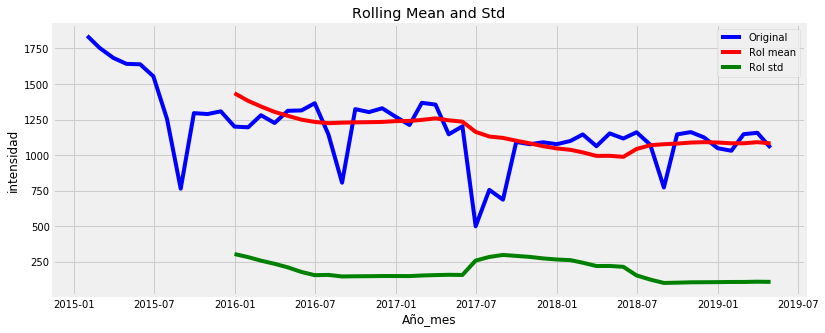

In [485]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_aguilera_WE = series_aguilera_WE.rolling(12).mean()
rolstd_aguilera_WE = series_aguilera_WE.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_aguilera_WE, label = 'Original', color = 'blue')
plt.plot(rolmean_aguilera_WE, label = 'Rol mean', color = 'red')
plt.plot(rolstd_aguilera_WE, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

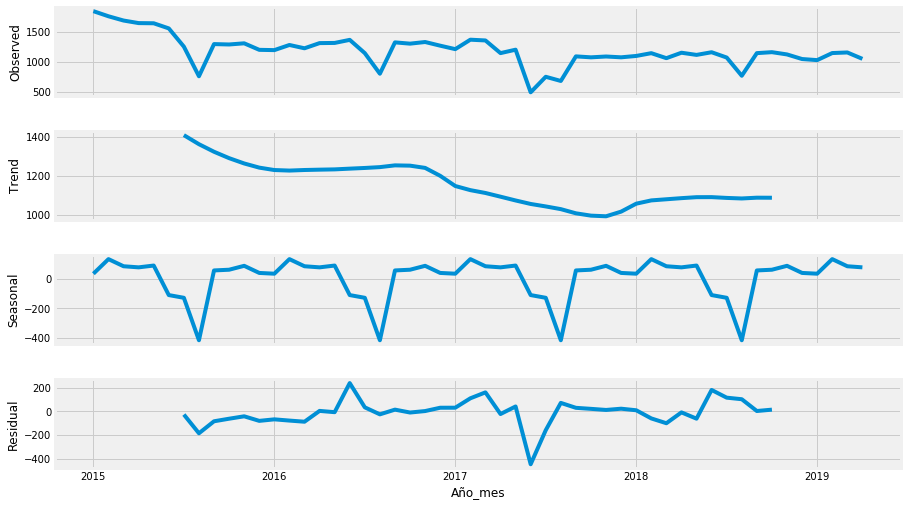

In [486]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_aguilera_WE, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [487]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_aguilera_WE, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
    
# the serie is stationary since the obtained p-value < 0.05

Test statistic: -3.8358535563326024
p-value: 0.00256106692673445
Lag: 0
Number of observations: 51
Critical Value (1%) = -3.5656240522121956
Critical Value (5%) = -2.920142229157715
Critical Value (10%) = -2.598014675124952


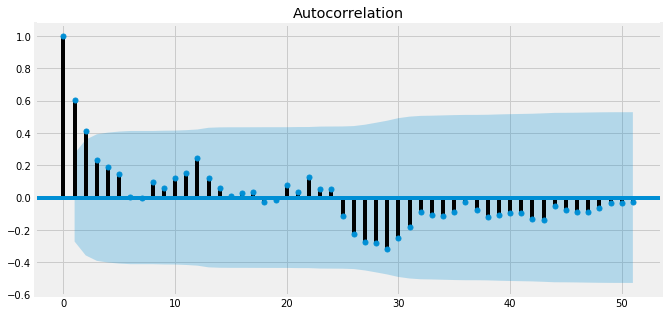

In [488]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_aguilera_WE)
fig.set_size_inches(10,5)

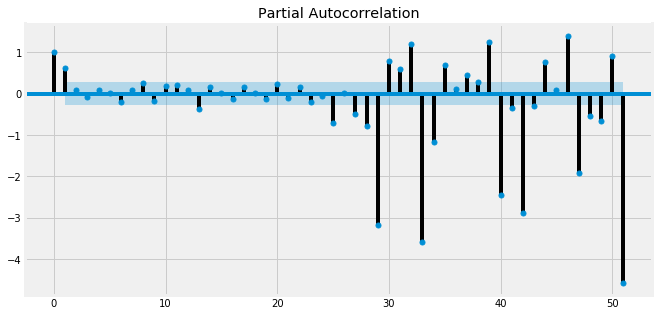

In [489]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_aguilera_WE)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [490]:
len(series_aguilera_WE)

52

In [491]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_aguilera_WE = series_aguilera_WE.loc['2015-01-31':'2018-12-31']
test_aguilera_WE = series_aguilera_WE.loc['2019-01-01':'2019-04-30']

In [492]:
len(train_aguilera_WE), len(test_aguilera_WE)

(48, 4)

In [493]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_aguilera_WE, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_aguilera_WE['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:821.2459435896808 - p-values:sigma2    0.145913
dtype: float64
The Mean Squared Error of our forecasts is 1205014.8
The Root Mean Squared Error of our forecasts is 1097.73
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:512.1225666730998 - p-values:sigma2    3.594588e-08
dtype: float64
The Mean Squared Error of our forecasts is 5949.31
The Root Mean Squared Error of our forecasts is 77.13
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:719.5996074524692 - p-values:ar.S.L12    0.000000e+00
sigma2      1.823017e-07
dtype: float64
The Mean Squared Error of our forecasts is 5608.8
The Root Mean Squared Error of our forecasts is 74.89
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:509.40263967341264 - p-values:ar.S.L12    1.386332e-02
sigma2      5.628413e-10
dtype: float64
The Mean Squared Error of our forecasts is 7427.65
The Root Mean Squared Error of our forecasts is 86.18
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:773.7008838770308 - p-values:ma.L1     4.127402e-13
sigma2    1.552889e-0

In [494]:
# We select the model SARIMAX(0, 1, 1)x(1, 1, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_aguilera_WE,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -232.525
Date:                            Thu, 16 May 2019   AIC                            471.050
Time:                                    12:17:43   BIC                            475.716
Sample:                                01-31-2015   HQIC                           472.661
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4210      0.163     -2.580      0.010      -0.741      -0.101
ar.S.L12      -0.6025      0.114   

In [495]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([1837.89894419,  -66.70731785,  -71.47539323,  -43.5346189 ,
         -3.78816555,  -84.68582831, -302.04192922, -494.78276114,
        521.54596048,    3.38336458,   19.25957807, -117.84873174,
       -919.96726922,  133.55568262,   61.98980477,  152.53330248,
         70.21636138,  165.428792  ,  146.8917137 ,  193.03187028,
         88.79357869,   16.68269756,   17.07420371,   69.35135676,
       -120.91391741,  137.71906116,  106.58511171, -172.95217085,
        -15.60002668, -678.5924713 ,  238.37328492,  461.09498003,
         74.30820238,   27.72731081,    3.00746608,   76.78721106,
         80.35042279,  -33.21608135,  -58.80776661,   96.58037951,
        -19.3003247 ,  284.67582356,   62.81356868,  -42.39016777,
       -117.40990133,  -14.55258932,  -65.07814212,  -61.6936904 ])

In [496]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.734 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=4.4241755450757125, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [497]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 0.01688272,  0.2599137 ,  0.51251831,  0.99338108,  1.38931291,
         1.73035131,  4.00509957,  5.15400457,  5.15480393,  5.15509889,
         5.22996015, 12.6322126 ]),
 array([0.89661903, 0.87813332, 0.91613271, 0.91079797, 0.92547875,
        0.94275412, 0.77918985, 0.74099627, 0.82061014, 0.88057922,
        0.91952004, 0.39632977]),
 array([0.01586975, 0.23945826, 0.46680241, 0.88996165, 1.23046302,
        1.51693528, 3.38222885, 4.30135284, 4.30197635, 4.30220052,
        4.35759785, 9.68721961]),
 array([0.89975155, 0.88716071, 0.92612184, 0.92599655, 0.94192168,
        0.95836168, 0.84753772, 0.82896245, 0.89043726, 0.93268615,
        0.95826601, 0.64337932]))

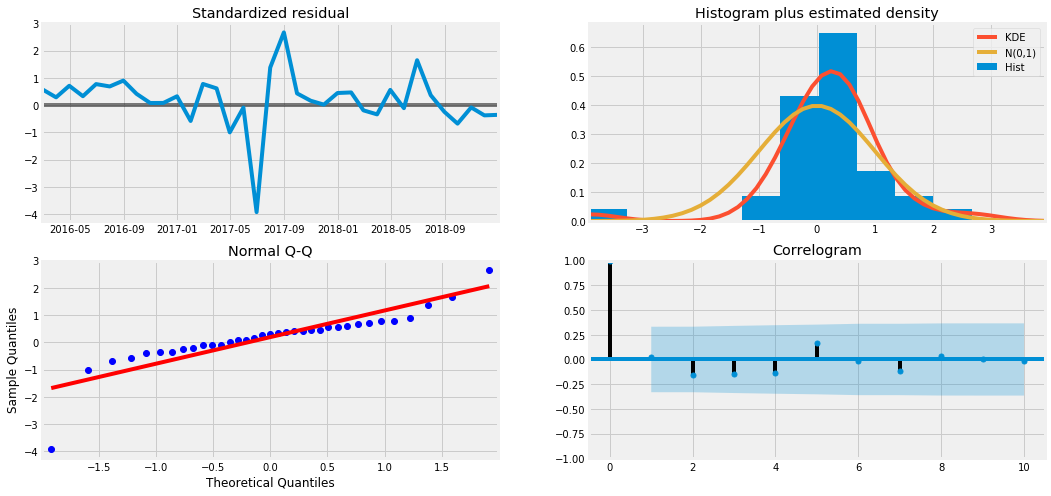

In [498]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

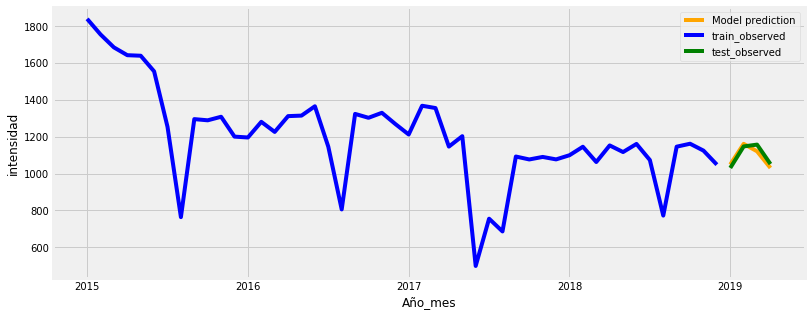

In [499]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_aguilera_WE.plot(color = 'blue', label = 'train_observed')
test_aguilera_WE.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [500]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    1048.744607
2019-02-28    1160.783576
2019-03-31    1120.497305
2019-04-30    1030.364676
Freq: M, dtype: float64

In [501]:
# Test values to compare vs forecasted values

y_truth = test_aguilera_WE['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    1030.317837
2019-02-28    1146.857668
2019-03-31    1156.644699
2019-04-30    1051.377619
Freq: M, Name: intensidad, dtype: float64

In [502]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_aguilera_WE['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 570.41
The Root Mean Squared Error of our forecasts is 23.88


## Applying the model

In [503]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(train_aguilera_WE,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         intensidad   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -232.525
Date:                            Thu, 16 May 2019   AIC                            471.050
Time:                                    12:17:58   BIC                            475.716
Sample:                                01-31-2015   HQIC                           472.661
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4210      0.163     -2.580      0.010      -0.741      -0.101
ar.S.L12      -0.6025      0.114   

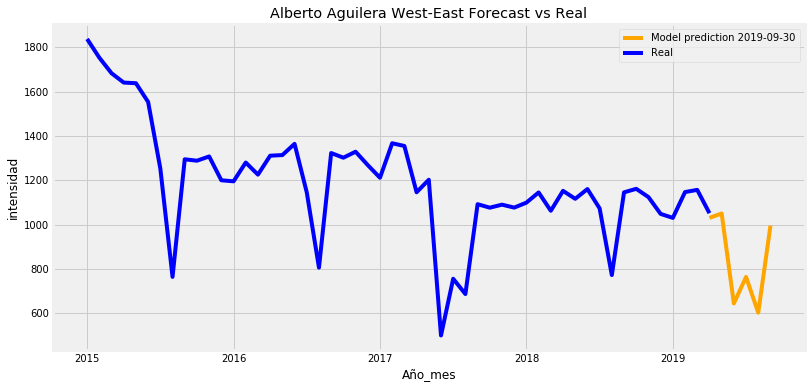

In [505]:
# Plot to forecast

plt.figure(figsize=(12,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_aguilera_WE.plot(color = 'blue', label='Real')

plt.title('Alberto Aguilera West-East Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

## Focus on GRAN VIA DE SAN FRANCISCO North-South

In [530]:
# For this time it is not necessary to split the dataframe

gvsanfran_NS = final_data[final_data['id'] == 3478]

In [531]:
# If we want to do time series manipulation, we need to have a datetime index so that our data frame is indexed on the timestamp.

# Convert the data frame index to a datetime index then show the first elements.
# The analysis will focus mainly on the variable 'intensidad' but for future analysis, I include more variables

gvsanfran_NS = gvsanfran_NS.loc[:, ['Año_mes','fecha', 'Hour24','intensidad','carga','volumen','ocupacion','Madrid-Central']]
gvsanfran_NS = gvsanfran_NS.set_index(gvsanfran_NS['Año_mes'])
gvsanfran_NS.index = pd.to_datetime(gvsanfran_NS.index)

# Time series of average 'intensidad'. Quick remind about what 'intensidad' is: vehicles/hour on a period of 15 min.
# Intensidad is a very good index about the traffic demand on a certain point. Normally it is considered as an average of a..
# ..certain period of time. We are going to focus monthly

series_gvsanfran_NS = gvsanfran_NS['intensidad'].resample('M').mean()

Text(0.5, 1.0, 'Time Series Gran Via de San Francisco North-South')

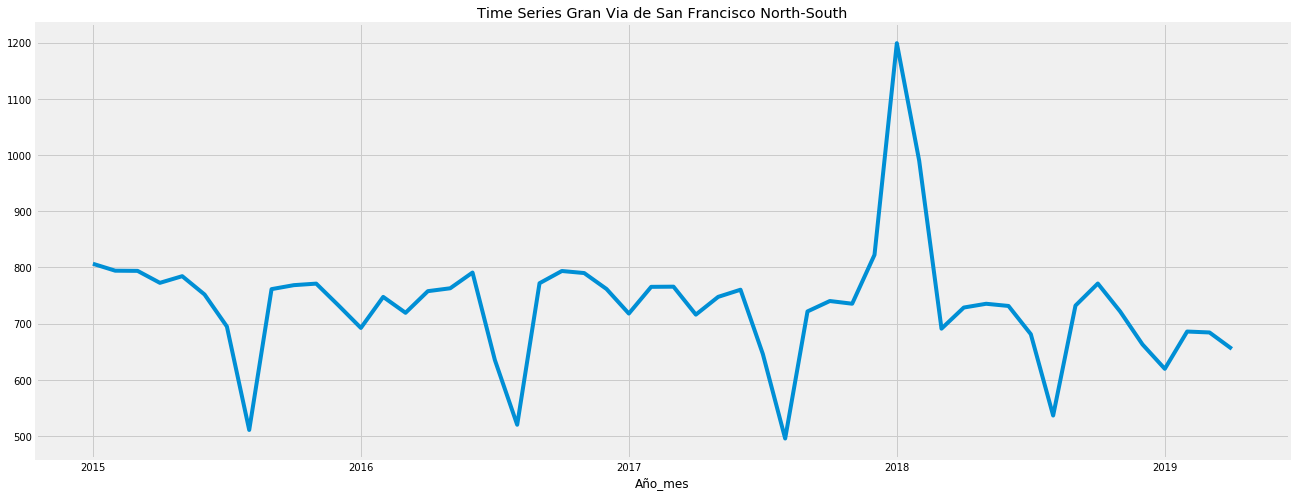

In [532]:
# As indicated in the time series process image displayed before a good start for time series is having a visual look..
# ..to see what the series is telling us

plt.figure(figsize=(20,8))
series_gvsanfran_NS.plot()
plt.title('Time Series Gran Via de San Francisco North-South')

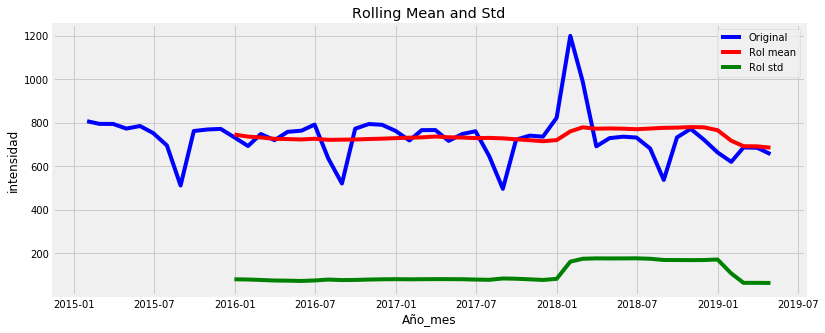

In [533]:
# Displaying rolling mean and std is a first step to see if the serie is stationary or not
# They look quite constant so it is good sign for stationarity but more actions need to be done

rolmean_gvsanfran_NS = series_gvsanfran_NS.rolling(12).mean()
rolstd_gvsanfran_NS = series_gvsanfran_NS.rolling(12).std()


plt.figure(figsize=(12,5))
plt.plot(series_gvsanfran_NS, label = 'Original', color = 'blue')
plt.plot(rolmean_gvsanfran_NS, label = 'Rol mean', color = 'red')
plt.plot(rolstd_gvsanfran_NS, label = 'Rol std', color = 'green')
plt.title('Rolling Mean and Std')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

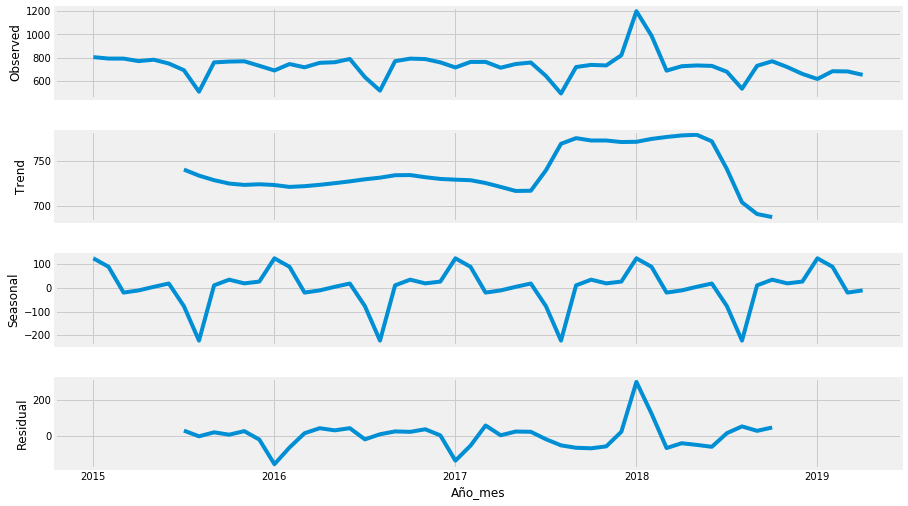

In [534]:
# Here I decompose the serie to focus on the 3 main features of a times series:
# 1. Trend
# 2. Stationality
# 3. Residuals

# There is one method that automatically decompose the series "seasonal_decompose()"

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series_gvsanfran_NS, model = 'additive') # Our serie is additive

trend = decomposition.trend
seasonal = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14,8)
plt.show()

In [535]:
# To be 100% sure if the serie is stationary, let's perform the adfuller test to confirm whether or not the serie is stationary:
# If p-value < 0.05 we can confirm the serie is stationary. If not, we will need to perform differences to make it stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series_gvsanfran_NS, autolag='AIC')
print('Test statistic: {}'.format(dftest[0]))
print('p-value: {}'.format(dftest[1]))
print('Lag: {}'.format(dftest[2]))
print('Number of observations: {}'.format(dftest[3]))
for key, value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key, value))
# We can confirm the serie is stationary since the obtained p-value < 0.05

Test statistic: -4.902913496471769
p-value: 3.4421813513088885e-05
Lag: 1
Number of observations: 50
Critical Value (1%) = -3.568485864
Critical Value (5%) = -2.92135992
Critical Value (10%) = -2.5986616


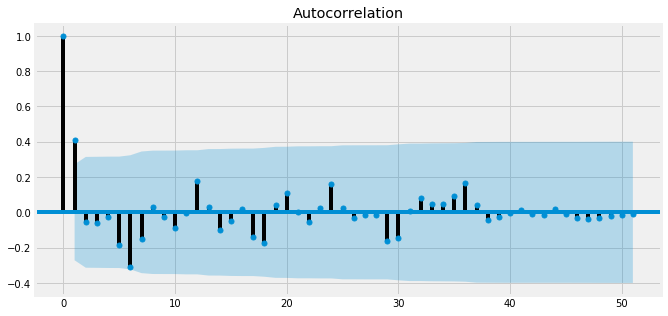

In [536]:
# Let's now display the ACF and PACF
# ACF: 
    #  it gives us values of auto-correlation of any series with its lagged values.
    #  it describes how well the present value of the series is related with its past values.
    #  it gives us values of auto-correlation of any series with its lagged values.
# PACF: 
    # it finds correlation of the residuals

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(series_gvsanfran_NS)
fig.set_size_inches(10,5)

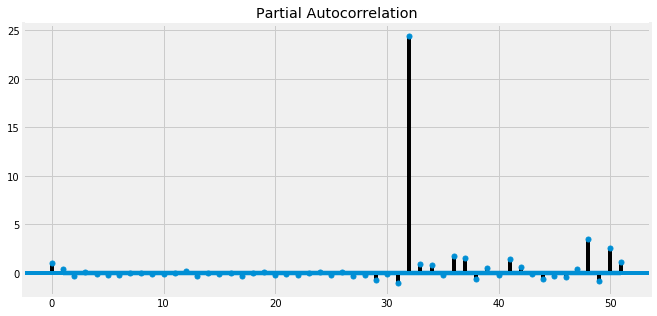

In [537]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_pacf(series_gvsanfran_NS)
fig.set_size_inches(10,5)

### Now it it time to build the model

In [538]:
len(series_gvsanfran_NS)

52

In [539]:
# Split the series in 2 parts:
    # train: to train the model
    # test: to measure if the model is good or not

train_gvsanfran_NS = series_gvsanfran_NS.loc['2015-01-31':'2018-12-31']
test_gvsanfran_NS = series_gvsanfran_NS.loc['2019-01-01':'2019-04-30']

In [540]:
len(train_gvsanfran_NS), len(test_gvsanfran_NS)

(48, 4)

In [541]:
# Since the serie has stationality, it is necessary to use a SARIMA model to consider the seasonal order
# SARIMA (p,d,q) x (P,D,Q): the first part is for the trend and the second one for the stationality

# In order to select the best MODEL, we make our analysis on the train part and we check the accuracy of the model comparing..
# ..the result of our prediction vs the real value obtained on the test part for each period forecasted with the model
# The 4 main features we are looking for are:
    # Min AIC possible: it basically quantifies 1) the goodness of fit 2) the simplicity of the model
    # coefficients p-values < 0.05
    # Residuals Normally Distributed and no correlated (otherwise it means they have some information we are missing to add to our model)
    # RMSE (root mean square error): the lowest result of real (test) vs forecast (model)
    
# With the code below we get all the possibilities from a range (0,2) for the p, d, q to select the one that fits the most

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_gvsanfran_NS, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=True, 
                                            enforce_invertibility=True)

            model = mod.fit()
            y_forecasted = model.predict('2019-01-31','2019-04-30')
            y_truth = test_gvsanfran_NS['2019-01-31':'2019-04-30']
            mse = ((y_forecasted - y_truth) ** 2).mean()
            print('ARIMA{}x{}12 - AIC:{} - p-values:{}'.format(param, param_seasonal, model.aic, model.pvalues))
            print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
            print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:773.4000404990738 - p-values:sigma2    0.280964
dtype: float64
The Mean Squared Error of our forecasts is 437983.79
The Root Mean Squared Error of our forecasts is 661.8
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:436.27970816107245 - p-values:sigma2    5.717818e-30
dtype: float64
The Mean Squared Error of our forecasts is 108389.78
The Root Mean Squared Error of our forecasts is 329.23
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:438.21770763136294 - p-values:ar.S.L12    9.344134e-01
sigma2      1.796555e-16
dtype: float64
The Mean Squared Error of our forecasts is 97108.51
The Root Mean Squared Error of our forecasts is 311.62
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.295433678435 - p-values:ma.L1     1.245347e-13
sigma2    4.504990e-02
dtype: float64
The Mean Squared Error of our forecasts is 389663.86
The Root Mean Squared Error of our forecasts is 624.23
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:429.1564444241445 - p-values:ma.L1     6.316360e-02
sigma2    3.855261

In [542]:
# We select the model SARIMAX(0, 1, 0)x(0, 0, 0, 12)
    # minimize the RMSE
    # all the coefficients have a p-value < 0.05
    # residuals are Normally distributed and show no correlation
        # Anderson test for Normally Distribution p-value > 0.05
        # p-values of Ljung-Box test for correlacion are > 0.05

mod = sm.tsa.statespace.SARIMAX(train_gvsanfran_NS,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -299.030
Date:                Thu, 16 May 2019   AIC                            602.060
Time:                        12:40:43   BIC                            605.802
Sample:                    01-31-2015   HQIC                           603.474
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9872      0.024     41.925      0.000       0.941       1.033
sigma2      1.397e+04   2111.638      6.618      0.000    9836.192    1.81e+04
Ljung-Box (Q):                       63.03   Jarque-

In [543]:
# We obtain the residuals in order to check if they have a normal distribution and no correlation

residuos = model.resid.values
residuos

array([ 806.5173454 ,   -2.0361621 ,    9.83115527,  -11.18597593,
         21.70548666,  -22.57568682,  -47.3955799 , -175.14823844,
        257.07178271,   16.79525957,   12.52471177,  -29.02066743,
        -30.62794413,   64.02354911,  -18.70611562,   47.65968129,
         14.78753949,   37.74961478, -145.49174796, -107.15106016,
        258.45412446,   31.59510875,    6.48466057,  -18.29013191,
        -33.9701449 ,   56.68344738,   10.07329656,  -39.95266722,
         40.72030297,   22.25732854, -104.6903565 , -142.12181724,
        232.453907  ,   27.73331146,    4.6405433 ,   96.35023552,
        387.04080037, -193.61052231, -286.34911555,   46.40289543,
         16.00111237,    5.49194156,  -40.91745847, -136.02759152,
        202.45431752,   48.61111517,  -39.90700155,  -49.37226805])

In [544]:
# In order to check if they show a Normal distribution, I perform a normality test for residuals
# As a result we can say that the p-value obtained for a significance level of 5% is 0.734 so it means...
# ..we can't reject the null hypothesis that they are Normally distributed => they show a Normal Distribution

from scipy.stats import anderson
anderson_result = anderson(residuos, dist = 'norm')
anderson_result

AndersonResult(statistic=3.3425897895269117, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [545]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos_corr = acorr_ljungbox(residuos, lags=12,boxpierce=True)
residuos_corr

# The returns are:
    # ljung-Box test statistic and it's pvalue
    # Box-Pierce statistic and it's pvalue
# p-values high so it means the residuals are independant and no correlated, we are not missing info from them

(array([ 0.18099603,  2.30994654,  2.35186825,  2.87139075,  2.97390061,
         4.24588922,  4.98912513,  8.10826838,  8.12388673,  8.51793744,
         8.75936312, 10.17327915]),
 array([0.67051866, 0.31506596, 0.50265721, 0.57957333, 0.70400977,
        0.64343956, 0.66129041, 0.42296629, 0.52171132, 0.57837968,
        0.64409323, 0.60076201]),
 array([0.17013627, 2.12877074, 2.16650027, 2.62368008, 2.71183856,
        3.78030899, 4.38976243, 6.88507704, 6.89725935, 7.19673788,
        7.37539289, 8.39341243]),
 array([0.67999073, 0.3449398 , 0.53857688, 0.62263408, 0.7443072 ,
        0.70637765, 0.73394783, 0.54908136, 0.64781539, 0.70675032,
        0.76791987, 0.75368065]))

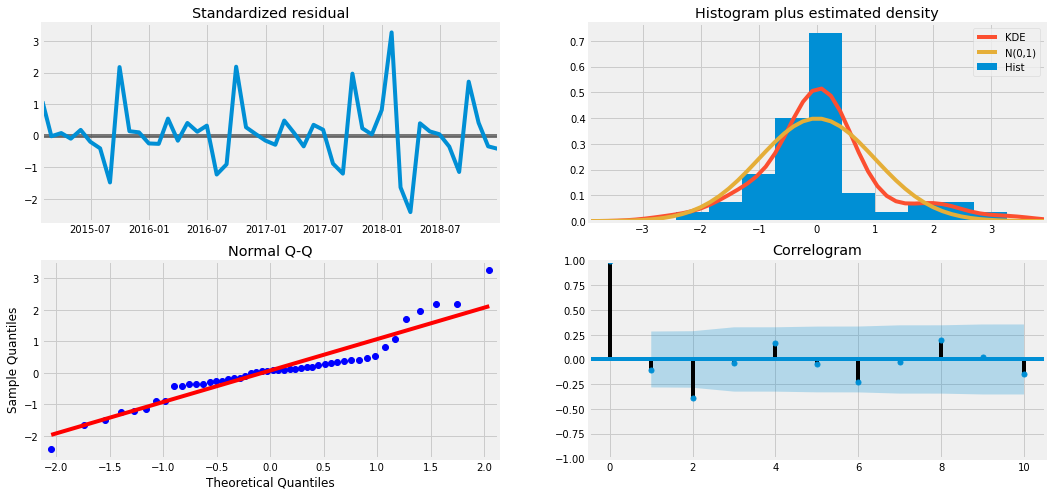

In [546]:
# Visualization of the residuals to confirm the results obtained in the cells above

model.plot_diagnostics(figsize=(16, 8))
plt.show()

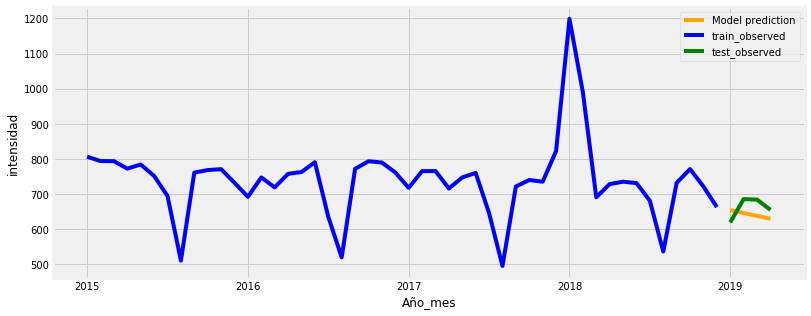

In [547]:
# Plot the model predicition vs train and test

plt.figure(figsize=(12,5))
forecast = model.predict('2019-01-31','2019-04-30').plot(color = 'orange', label = 'Model prediction')
train_gvsanfran_NS.plot(color = 'blue', label = 'train_observed')
test_gvsanfran_NS.plot(color = 'green', label = 'test_observed')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

In [548]:
# Let's make the predictions of our model for the months of the test part to see the RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_forecasted

2019-01-31    654.572052
2019-02-28    646.219797
2019-03-31    637.974116
2019-04-30    629.833648
Freq: M, dtype: float64

In [549]:
# Test values to compare vs forecasted values

y_truth = test_gvsanfran_NS['2019-01-31':'2019-04-30']
y_truth

Año_mes
2019-01-31    619.602948
2019-02-28    685.937434
2019-03-31    684.302292
2019-04-30    655.169858
Freq: M, Name: intensidad, dtype: float64

In [550]:
# Measure of the MSE and RMSE

y_forecasted = model.predict('2019-01-31','2019-04-30')
y_truth = test_gvsanfran_NS['2019-01-31':'2019-04-30']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1397.14
The Root Mean Squared Error of our forecasts is 37.38


## Applying the model

In [551]:
# Apply the model to the entire Serie

mod = sm.tsa.statespace.SARIMAX(train_gvsanfran_NS,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
model = mod.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             intensidad   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -299.030
Date:                Thu, 16 May 2019   AIC                            602.060
Time:                        12:40:46   BIC                            605.802
Sample:                    01-31-2015   HQIC                           603.474
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9872      0.024     41.925      0.000       0.941       1.033
sigma2      1.397e+04   2111.638      6.618      0.000    9836.192    1.81e+04
Ljung-Box (Q):                       63.03   Jarque-

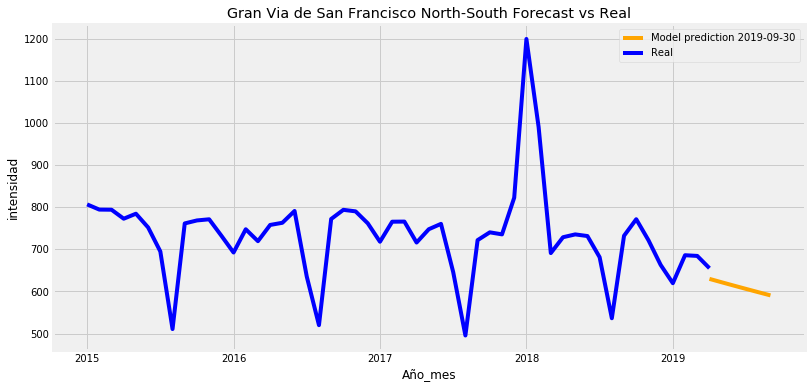

In [553]:
# Plot to forecast

plt.figure(figsize=(12,6))
forecast = model.predict('2019-04-30','2019-09-30').plot(color = 'orange', label='Model prediction 2019-09-30')
series_gvsanfran_NS.plot(color = 'blue', label='Real')

plt.title('Gran Via de San Francisco North-South Forecast vs Real')
plt.xlabel('Año_mes')
plt.ylabel('intensidad')
plt.legend()
plt.show()

#### Move to next notebook number 5